In [1]:
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import timeit
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

2023-06-06 18:14:46.383011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 18:14:46.512713: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-06 18:14:46.880318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/themandalorian/anaconda3/envs/ml-on-mc/lib/
2023-06-06 18:14:46.880370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: lib

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load the CIFAR-10 dataset
data_path = 'cifar-10-batches-py/'
train_data = []
train_labels = []
for i in range(1, 6):
    batch = unpickle(data_path + 'data_batch_' + str(i))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']
    
    
train_data = np.concatenate(train_data)
train_data = train_data.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)
test_data = unpickle(data_path + 'test_batch')[b'data']
test_data = test_data.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)
test_labels = np.array(unpickle(data_path + 'test_batch')[b'labels'])

# Print the number of features, classes, and training samples for CIFAR-10
print("CIFAR-10")
print("Number of features:", train_data.shape[1:])
print("Number of classes:", len(np.unique(train_labels)))
print("Number of training samples:", train_data.shape[0])

# Shuffle your dataset
train_data, train_labels = shuffle(train_data, train_labels, random_state=42)
test_data, test_labels = shuffle(test_data, test_labels, random_state=42)

# Normalize pixel values
x_train = train_data.astype('float32') / 255.0
x_test = test_data.astype('float32') / 255.0

# Convert labels to categorical format
y_train = to_categorical(train_labels, num_classes=10)
y_test = to_categorical(test_labels, num_classes=10)

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=64)
# fit model
steps = int(x_train.shape[0] / 64)

CIFAR-10
Number of features: (32, 32, 3)
Number of classes: 10
Number of training samples: 50000


In [3]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nstatic const unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'static const unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [4]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Print the model summary
model.summary()

2023-06-06 14:51:58.810208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 14:51:58.810408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 14:51:58.810530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 14:51:58.810779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 14:51:58.810911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model_10 = Sequential()
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG16_Base.h5', save_freq='epoch')

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model_10.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the quantization aware model
model_10.fit(it_train, steps_per_epoch=steps, epochs=400,
                      validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

781/781 [==============================] - 14s 17ms/step - loss: 0.5326 - accuracy: 0.8206 - val_loss: 0.4920 - val_accuracy: 0.8359
Epoch 84/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5228 - accuracy: 0.8268 - val_loss: 0.5292 - val_accuracy: 0.8332
Epoch 85/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5189 - accuracy: 0.8276 - val_loss: 0.5717 - val_accuracy: 0.8207
Epoch 86/400
781/781 [==============================] - 14s 17ms/step - loss: 0.5196 - accuracy: 0.8278 - val_loss: 0.5831 - val_accuracy: 0.8173
Epoch 87/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5137 - accuracy: 0.8273 - val_loss: 0.5039 - val_accuracy: 0.8369
Epoch 88/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5142 - accuracy: 0.8290 - val_loss: 0.5333 - val_accuracy: 0.8260
Epoch 89/400
781/781 [==============================] - 15s 19ms/step - loss: 0.5070 - accuracy: 0.8301 - val_loss: 0.4875 - val_accuracy

Epoch 139/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3864 - accuracy: 0.8707 - val_loss: 0.4508 - val_accuracy: 0.8590
Epoch 140/400
781/781 [==============================] - 15s 20ms/step - loss: 0.3802 - accuracy: 0.8733 - val_loss: 0.4577 - val_accuracy: 0.8570
Epoch 141/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3830 - accuracy: 0.8716 - val_loss: 0.4593 - val_accuracy: 0.8575
Epoch 142/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3797 - accuracy: 0.8737 - val_loss: 0.4739 - val_accuracy: 0.8534
Epoch 143/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3799 - accuracy: 0.8727 - val_loss: 0.4704 - val_accuracy: 0.8534
Epoch 144/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3785 - accuracy: 0.8731 - val_loss: 0.4496 - val_accuracy: 0.8583
Epoch 145/400
781/781 [==============================] - 14s 17ms/step - loss: 0.3753 - accuracy: 0.8746 - val_loss: 0

Epoch 195/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3018 - accuracy: 0.8984 - val_loss: 0.4745 - val_accuracy: 0.8620
Epoch 196/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3087 - accuracy: 0.8968 - val_loss: 0.4101 - val_accuracy: 0.8734
Epoch 197/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3061 - accuracy: 0.8966 - val_loss: 0.4315 - val_accuracy: 0.8675
Epoch 198/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3042 - accuracy: 0.8978 - val_loss: 0.4589 - val_accuracy: 0.8651
Epoch 199/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3088 - accuracy: 0.8965 - val_loss: 0.3991 - val_accuracy: 0.8771
Epoch 200/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3038 - accuracy: 0.8975 - val_loss: 0.4501 - val_accuracy: 0.8668
Epoch 201/400
781/781 [==============================] - 15s 19ms/step - loss: 0.2956 - accuracy: 0.9002 - val_loss: 0

In [5]:
# load the pre-saved model
model_10 = load_model('model_10_VGG16_Base.h5')

# test the accuracy of the model on the test set
loss, accuracy = model_10.evaluate(x_test, y_test)

# print the accuracy of the model on the test set
print('model_10_VGG16_Base.h5 Test accuracy:', accuracy)

2023-06-05 20:00:55.505560: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 40/313 [==>...........................] - ETA: 1s - loss: 0.5058 - accuracy: 0.8570

2023-06-05 20:00:56.657545: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 3s 4ms/step - loss: 0.4530 - accuracy: 0.8814
model_10_VGG16_Base.h5 Test accuracy: 0.8813999891281128


313/313 [==============================] - 1s 3ms/step
Confusion matrix, without normalization
[[933  11   7   5   3   2   2   2  25  10]
 [  3 972   0   0   0   1   1   0   3  20]
 [ 44   5 800  17  26  44  48   9   6   1]
 [ 17   8  25 683  30 145  59  16  11   6]
 [ 11   1  26  12 864  21  35  25   3   2]
 [  5   4  10  64  16 862  20  14   1   4]
 [  5   2  16  11   5   8 948   2   1   2]
 [  8   0  10   7  20  27   3 920   1   4]
 [ 37  20   3   2   1   1   3   2 921  10]
 [ 13  58   2   1   2   1   3   0   9 911]]


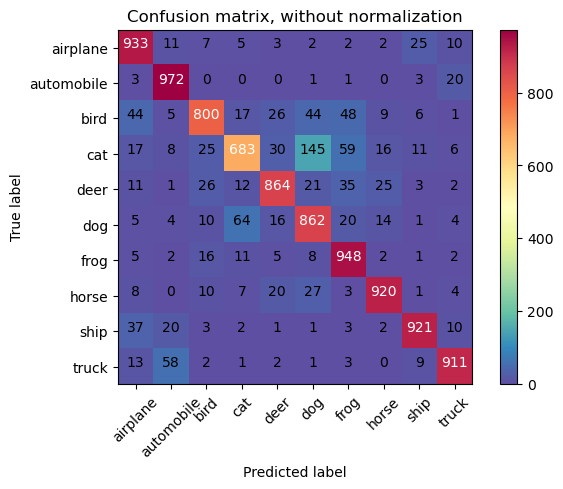

In [7]:
# Make predictions
y_pred = model_10.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [14]:
model_10 = Sequential()
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_10.add(BatchNormalization())
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(BatchNormalization())
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(BatchNormalization())
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG8_Base.h5', save_freq='epoch')

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model_10.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the quantization aware model
model_10.fit(it_train, steps_per_epoch=steps, epochs=400,
                      validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

313/313 [==============================] - 1s 2ms/step - loss: 0.3419 - accuracy: 0.8904
model_10_VGG8_Base.h5 Test accuracy: 0.8903999924659729
313/313 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[882   5  20   4   9   0   5   5  55  15]
 [  2 958   0   0   0   2   2   0   5  31]
 [ 30   1 847  18  32  21  39   5   3   4]
 [ 12   2  24 757  34  78  51  17  14  11]
 [  4   1  23  20 894   9  32  16   1   0]
 [  6   3  20  90  30 814  15  15   6   1]
 [  5   1  15  16   7   2 947   2   2   3]
 [  8   2  11  16  27  15   8 905   3   5]
 [ 22   4   2   3   0   0   1   0 956  12]
 [ 13  31   1   0   1   1   1   1   7 944]]


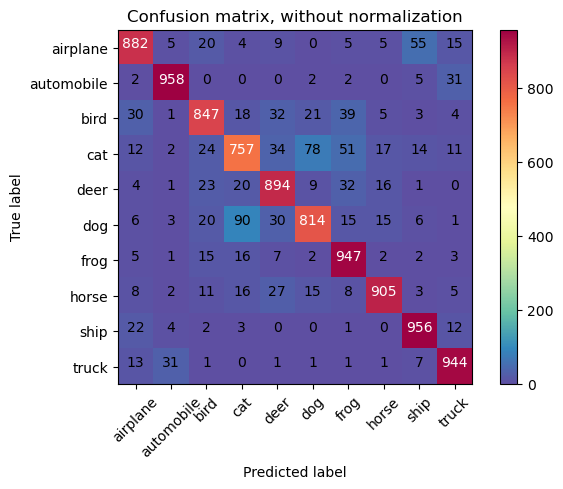

In [8]:
# load the pre-saved model
model_10 = load_model('model_10_VGG8_Base.h5')

# test the accuracy of the model on the test set
loss, accuracy = model_10.evaluate(x_test, y_test)

# print the accuracy of the model on the test set
print('model_10_VGG8_Base.h5 Test accuracy:', accuracy)

# Make predictions
y_pred = model_10.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [84]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG15_Base.h5', save_freq='epoch')

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model_10.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the quantization aware model
model_10.fit(it_train, steps_per_epoch=steps, epochs=400,
                      validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_920 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_921 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 dropout_445 (Dropout)       (None, 32, 32, 16)        0         
                                                                 
 conv2d_922 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 conv2d_923 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_344 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                     

Epoch 29/400
781/781 [==============================] - 13s 17ms/step - loss: 1.0970 - accuracy: 0.6121 - val_loss: 0.9757 - val_accuracy: 0.6560
Epoch 30/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0917 - accuracy: 0.6149 - val_loss: 1.0225 - val_accuracy: 0.6387
Epoch 31/400
781/781 [==============================] - 13s 17ms/step - loss: 1.0689 - accuracy: 0.6222 - val_loss: 0.9568 - val_accuracy: 0.6593
Epoch 32/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0508 - accuracy: 0.6315 - val_loss: 1.0037 - val_accuracy: 0.6516
Epoch 33/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0307 - accuracy: 0.6373 - val_loss: 0.9762 - val_accuracy: 0.6539
Epoch 34/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0221 - accuracy: 0.6423 - val_loss: 0.9526 - val_accuracy: 0.6615
Epoch 35/400
781/781 [==============================] - 14s 18ms/step - loss: 1.0131 - accuracy: 0.6447 - val_loss: 0.9464 -

Epoch 141/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4762 - accuracy: 0.8404 - val_loss: 0.4657 - val_accuracy: 0.8459
Epoch 142/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4735 - accuracy: 0.8402 - val_loss: 0.4763 - val_accuracy: 0.8463
Epoch 143/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4670 - accuracy: 0.8448 - val_loss: 0.4441 - val_accuracy: 0.8518
Epoch 144/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4690 - accuracy: 0.8447 - val_loss: 0.4749 - val_accuracy: 0.8460
Epoch 145/400
781/781 [==============================] - 13s 17ms/step - loss: 0.4635 - accuracy: 0.8459 - val_loss: 0.5052 - val_accuracy: 0.8389
Epoch 146/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4695 - accuracy: 0.8438 - val_loss: 0.4644 - val_accuracy: 0.8511
Epoch 147/400
781/781 [==============================] - 14s 17ms/step - loss: 0.4683 - accuracy: 0.8462 - val_loss: 0

Epoch 197/400
781/781 [==============================] - 14s 17ms/step - loss: 0.3898 - accuracy: 0.8689 - val_loss: 0.4188 - val_accuracy: 0.8657
Epoch 198/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3818 - accuracy: 0.8728 - val_loss: 0.4468 - val_accuracy: 0.8588
Epoch 199/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3818 - accuracy: 0.8712 - val_loss: 0.4136 - val_accuracy: 0.8656
Epoch 200/400
781/781 [==============================] - 13s 16ms/step - loss: 0.3858 - accuracy: 0.8714 - val_loss: 0.4492 - val_accuracy: 0.8589
Epoch 201/400
781/781 [==============================] - 14s 17ms/step - loss: 0.3797 - accuracy: 0.8722 - val_loss: 0.4156 - val_accuracy: 0.8654
Epoch 202/400
781/781 [==============================] - 14s 17ms/step - loss: 0.3811 - accuracy: 0.8707 - val_loss: 0.4227 - val_accuracy: 0.8636
Epoch 203/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3817 - accuracy: 0.8728 - val_loss: 0

Epoch 253/400
781/781 [==============================] - 13s 16ms/step - loss: 0.3312 - accuracy: 0.8876 - val_loss: 0.4025 - val_accuracy: 0.8728
Epoch 254/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3279 - accuracy: 0.8899 - val_loss: 0.3937 - val_accuracy: 0.8790
Epoch 255/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3267 - accuracy: 0.8897 - val_loss: 0.4135 - val_accuracy: 0.8696
Epoch 256/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3230 - accuracy: 0.8909 - val_loss: 0.4020 - val_accuracy: 0.8731
Epoch 257/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3217 - accuracy: 0.8935 - val_loss: 0.4182 - val_accuracy: 0.8695
Epoch 258/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3244 - accuracy: 0.8915 - val_loss: 0.4113 - val_accuracy: 0.8697
Epoch 259/400
781/781 [==============================] - 13s 17ms/step - loss: 0.3230 - accuracy: 0.8917 - val_loss: 0

Epoch 309/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2872 - accuracy: 0.9026 - val_loss: 0.4052 - val_accuracy: 0.8749
Epoch 310/400
781/781 [==============================] - 13s 16ms/step - loss: 0.2918 - accuracy: 0.9010 - val_loss: 0.4164 - val_accuracy: 0.8747
Epoch 311/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2876 - accuracy: 0.9026 - val_loss: 0.4139 - val_accuracy: 0.8734
Epoch 312/400
781/781 [==============================] - 14s 18ms/step - loss: 0.2856 - accuracy: 0.9039 - val_loss: 0.3872 - val_accuracy: 0.8814
Epoch 313/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2833 - accuracy: 0.9044 - val_loss: 0.4088 - val_accuracy: 0.8723
Epoch 314/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2878 - accuracy: 0.9021 - val_loss: 0.3990 - val_accuracy: 0.8739
Epoch 315/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2877 - accuracy: 0.9022 - val_loss: 0

Epoch 365/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2605 - accuracy: 0.9116 - val_loss: 0.3616 - val_accuracy: 0.8881
Epoch 366/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2588 - accuracy: 0.9123 - val_loss: 0.3856 - val_accuracy: 0.8802
Epoch 367/400
781/781 [==============================] - 14s 18ms/step - loss: 0.2542 - accuracy: 0.9139 - val_loss: 0.3739 - val_accuracy: 0.8855
Epoch 368/400
781/781 [==============================] - 14s 18ms/step - loss: 0.2541 - accuracy: 0.9151 - val_loss: 0.3499 - val_accuracy: 0.8939
Epoch 369/400
781/781 [==============================] - 13s 16ms/step - loss: 0.2553 - accuracy: 0.9132 - val_loss: 0.3762 - val_accuracy: 0.8862
Epoch 370/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2568 - accuracy: 0.9140 - val_loss: 0.3663 - val_accuracy: 0.8879
Epoch 371/400
781/781 [==============================] - 13s 17ms/step - loss: 0.2540 - accuracy: 0.9140 - val_loss: 0

313/313 [==============================] - 1s 3ms/step - loss: 0.3522 - accuracy: 0.8942
model_10_VGG15_Base.h5 Test accuracy: 0.8942000269889832
313/313 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[901   6  22   3   9   0   7   3  38  11]
 [  3 970   1   1   0   0   0   0   6  19]
 [ 22   2 844  17  32  20  44  14   2   3]
 [ 10   2  41 747  32  76  57  20   4  11]
 [  6   2  22  16 891   6  32  24   0   1]
 [  6   1  21  82  33 806  17  30   0   4]
 [  3   1   9  15   7   2 958   2   2   1]
 [  8   0   6   9  22  10   5 938   1   1]
 [ 16   8   4   5   4   1   3   1 944  14]
 [  4  39   1   2   1   0   3   1   6 943]]


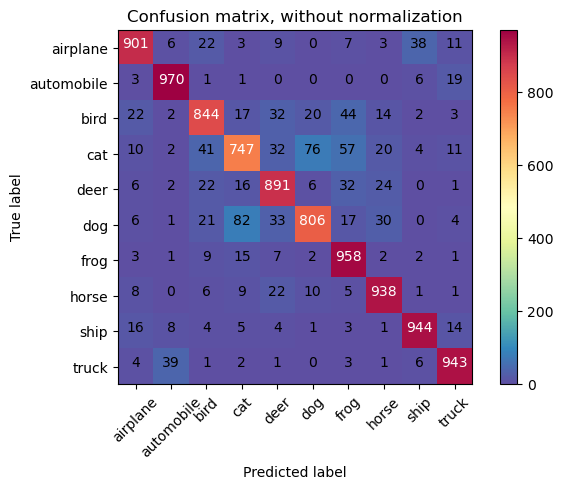

In [9]:
# load the pre-saved model
model_10 = load_model('model_10_VGG15_Base.h5')

# test the accuracy of the model on the test set
loss, accuracy = model_10.evaluate(x_test, y_test)

# print the accuracy of the model on the test set
print('model_10_VGG15_Base.h5 Test accuracy:', accuracy)

# Make predictions
y_pred = model_10.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [90]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG12_Base.h5', save_freq='epoch')

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model_10.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the quantization aware model
model_10.fit(it_train, steps_per_epoch=steps, epochs=400,
                      validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_979 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_980 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 dropout_475 (Dropout)       (None, 32, 32, 16)        0         
                                                                 
 conv2d_981 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 conv2d_982 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_364 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                     

/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


781/781 [==============================] - 15s 18ms/step - loss: 2.2575 - accuracy: 0.1561 - val_loss: 2.1627 - val_accuracy: 0.2199
Epoch 2/400
781/781 [==============================] - 16s 20ms/step - loss: 2.1116 - accuracy: 0.2004 - val_loss: 2.1177 - val_accuracy: 0.1918
Epoch 3/400
781/781 [==============================] - 14s 18ms/step - loss: 1.9997 - accuracy: 0.2169 - val_loss: 1.9502 - val_accuracy: 0.2357
Epoch 4/400
781/781 [==============================] - 15s 19ms/step - loss: 1.9246 - accuracy: 0.2488 - val_loss: 1.8245 - val_accuracy: 0.3032
Epoch 5/400
781/781 [==============================] - 14s 17ms/step - loss: 1.8442 - accuracy: 0.2858 - val_loss: 1.7600 - val_accuracy: 0.3309
Epoch 6/400
781/781 [==============================] - 14s 18ms/step - loss: 1.7766 - accuracy: 0.3172 - val_loss: 1.7120 - val_accuracy: 0.3573
Epoch 7/400
781/781 [==============================] - 14s 18ms/step - loss: 1.7247 - accuracy: 0.3400 - val_loss: 1.6124 - val_accuracy: 0.39

781/781 [==============================] - 14s 17ms/step - loss: 0.6509 - accuracy: 0.7802 - val_loss: 0.6296 - val_accuracy: 0.7896
Epoch 114/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6446 - accuracy: 0.7814 - val_loss: 0.6106 - val_accuracy: 0.7998
Epoch 115/400
781/781 [==============================] - 15s 19ms/step - loss: 0.6482 - accuracy: 0.7824 - val_loss: 0.5767 - val_accuracy: 0.8038
Epoch 116/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6404 - accuracy: 0.7826 - val_loss: 0.5765 - val_accuracy: 0.8065
Epoch 117/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6431 - accuracy: 0.7811 - val_loss: 0.5887 - val_accuracy: 0.8031
Epoch 118/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6354 - accuracy: 0.7834 - val_loss: 0.5592 - val_accuracy: 0.8114
Epoch 119/400
781/781 [==============================] - 14s 18ms/step - loss: 0.6381 - accuracy: 0.7839 - val_loss: 0.5960 - val_ac

Epoch 169/400
781/781 [==============================] - 15s 19ms/step - loss: 0.5299 - accuracy: 0.8226 - val_loss: 0.5335 - val_accuracy: 0.8255
Epoch 170/400
781/781 [==============================] - 15s 19ms/step - loss: 0.5347 - accuracy: 0.8206 - val_loss: 0.4954 - val_accuracy: 0.8376
Epoch 171/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5354 - accuracy: 0.8191 - val_loss: 0.5363 - val_accuracy: 0.8215
Epoch 172/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5304 - accuracy: 0.8232 - val_loss: 0.4851 - val_accuracy: 0.8419
Epoch 173/400
781/781 [==============================] - 15s 19ms/step - loss: 0.5318 - accuracy: 0.8217 - val_loss: 0.5157 - val_accuracy: 0.8272
Epoch 174/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5307 - accuracy: 0.8219 - val_loss: 0.4968 - val_accuracy: 0.8375
Epoch 175/400
781/781 [==============================] - 14s 18ms/step - loss: 0.5305 - accuracy: 0.8212 - val_loss: 0

Epoch 225/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4668 - accuracy: 0.8439 - val_loss: 0.4966 - val_accuracy: 0.8421
Epoch 226/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4647 - accuracy: 0.8441 - val_loss: 0.4472 - val_accuracy: 0.8543
Epoch 227/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4635 - accuracy: 0.8440 - val_loss: 0.4680 - val_accuracy: 0.8484
Epoch 228/400
781/781 [==============================] - 14s 17ms/step - loss: 0.4619 - accuracy: 0.8458 - val_loss: 0.5228 - val_accuracy: 0.8337
Epoch 229/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4615 - accuracy: 0.8445 - val_loss: 0.4695 - val_accuracy: 0.8486
Epoch 230/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4634 - accuracy: 0.8439 - val_loss: 0.4731 - val_accuracy: 0.8472
Epoch 231/400
781/781 [==============================] - 14s 18ms/step - loss: 0.4606 - accuracy: 0.8457 - val_loss: 0

Epoch 281/400
781/781 [==============================] - 15s 20ms/step - loss: 0.4170 - accuracy: 0.8598 - val_loss: 0.4477 - val_accuracy: 0.8587
Epoch 282/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4205 - accuracy: 0.8585 - val_loss: 0.4495 - val_accuracy: 0.8575
Epoch 283/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4216 - accuracy: 0.8582 - val_loss: 0.4509 - val_accuracy: 0.8560
Epoch 284/400
781/781 [==============================] - 15s 20ms/step - loss: 0.4202 - accuracy: 0.8595 - val_loss: 0.4550 - val_accuracy: 0.8530
Epoch 285/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4177 - accuracy: 0.8587 - val_loss: 0.4109 - val_accuracy: 0.8679
Epoch 286/400
781/781 [==============================] - 15s 19ms/step - loss: 0.4157 - accuracy: 0.8612 - val_loss: 0.4208 - val_accuracy: 0.8639
Epoch 287/400
781/781 [==============================] - 15s 20ms/step - loss: 0.4090 - accuracy: 0.8630 - val_loss: 0

Epoch 337/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3830 - accuracy: 0.8704 - val_loss: 0.4074 - val_accuracy: 0.8707
Epoch 338/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3800 - accuracy: 0.8734 - val_loss: 0.4016 - val_accuracy: 0.8748
Epoch 339/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3794 - accuracy: 0.8721 - val_loss: 0.4265 - val_accuracy: 0.8662
Epoch 340/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3794 - accuracy: 0.8714 - val_loss: 0.4161 - val_accuracy: 0.8687
Epoch 341/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3804 - accuracy: 0.8728 - val_loss: 0.4159 - val_accuracy: 0.8662
Epoch 342/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3836 - accuracy: 0.8720 - val_loss: 0.4306 - val_accuracy: 0.8639
Epoch 343/400
781/781 [==============================] - 14s 18ms/step - loss: 0.3798 - accuracy: 0.8719 - val_loss: 0

Epoch 393/400
321/781 [===========>..................] - ETA: 7s - loss: 0.3556 - accuracy: 0.8773

313/313 [==============================] - 1s 3ms/step - loss: 0.4116 - accuracy: 0.8717
model_10_VGG12_Base.h5 Test accuracy: 0.8716999888420105
313/313 [==============================] - 1s 2ms/step
Confusion matrix, without normalization
[[890   9  22  14   9   0  11   9  20  16]
 [  2 956   1   1   0   0   3   0   5  32]
 [ 30   1 791  18  34  23  78  18   3   4]
 [  7   4  32 714  35  86  89  25   2   6]
 [  4   1  24  17 862   6  54  31   1   0]
 [  4   3  22 102  30 767  43  28   1   0]
 [  3   0  12   9   4   3 962   3   2   2]
 [  3   0  10  14  25   7  14 922   2   3]
 [ 38  13   4   4   2   0  11   2 911  15]
 [  8  34   3   1   1   0   4   0   7 942]]


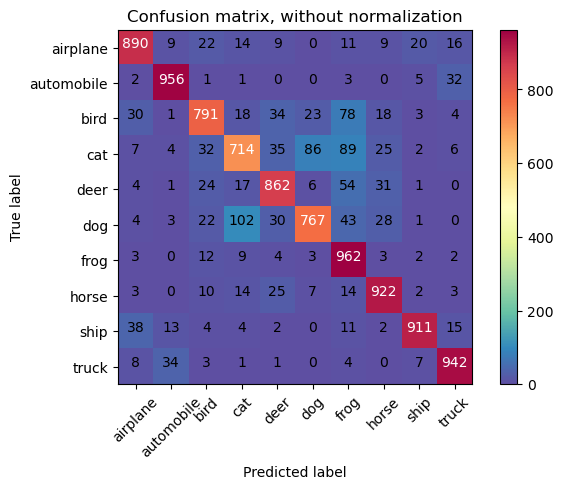

In [10]:
# load the pre-saved model
model_10 = load_model('model_10_VGG12_Base.h5')

# test the accuracy of the model on the test set
loss, accuracy = model_10.evaluate(x_test, y_test)

# print the accuracy of the model on the test set
print('model_10_VGG12_Base.h5 Test accuracy:', accuracy)

# Make predictions
y_pred = model_10.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [14]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG15_Base_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=400,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_3 (QuantizeL  (None, 32, 32, 3)        3         
 ayer)                                                           
                                                                 
 quant_conv2d_39 (QuantizeWr  (None, 32, 32, 16)       483       
 apperV2)                                                        
                                                                 
 quant_conv2d_40 (QuantizeWr  (None, 32, 32, 16)       2355      
 apperV2)                                                        
                                                                 
 quant_dropout_18 (QuantizeW  (None, 32, 32, 16)       1         
 rapperV2)                                                       
                                                                 
 quant_conv2d_41 (QuantizeWr  (None, 32, 32, 32)      

781/781 [==============================] - 26s 33ms/step - loss: 1.2207 - accuracy: 0.5644 - val_loss: 1.1107 - val_accuracy: 0.6007
Epoch 18/400
781/781 [==============================] - 26s 33ms/step - loss: 1.1909 - accuracy: 0.5729 - val_loss: 1.0687 - val_accuracy: 0.6157
Epoch 19/400
781/781 [==============================] - 26s 33ms/step - loss: 1.1608 - accuracy: 0.5848 - val_loss: 1.0515 - val_accuracy: 0.6168
Epoch 20/400
781/781 [==============================] - 26s 33ms/step - loss: 1.1342 - accuracy: 0.5946 - val_loss: 0.9909 - val_accuracy: 0.6454
Epoch 21/400
781/781 [==============================] - 26s 33ms/step - loss: 1.0986 - accuracy: 0.6101 - val_loss: 1.0336 - val_accuracy: 0.6296
Epoch 22/400
781/781 [==============================] - 26s 33ms/step - loss: 1.0869 - accuracy: 0.6136 - val_loss: 0.9739 - val_accuracy: 0.6499
Epoch 23/400
781/781 [==============================] - 26s 33ms/step - loss: 1.0560 - accuracy: 0.6266 - val_loss: 0.9347 - val_accuracy

781/781 [==============================] - 26s 33ms/step - loss: 0.5464 - accuracy: 0.8153 - val_loss: 0.5961 - val_accuracy: 0.8037
Epoch 74/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5349 - accuracy: 0.8183 - val_loss: 0.6021 - val_accuracy: 0.8024
Epoch 75/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5272 - accuracy: 0.8204 - val_loss: 0.6054 - val_accuracy: 0.8082
Epoch 76/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5285 - accuracy: 0.8209 - val_loss: 0.6092 - val_accuracy: 0.8028
Epoch 77/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5206 - accuracy: 0.8229 - val_loss: 0.5813 - val_accuracy: 0.8128
Epoch 78/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5185 - accuracy: 0.8247 - val_loss: 0.5861 - val_accuracy: 0.8040
Epoch 79/400
781/781 [==============================] - 26s 33ms/step - loss: 0.5037 - accuracy: 0.8285 - val_loss: 0.5826 - val_accuracy

781/781 [==============================] - 26s 33ms/step - loss: 0.3399 - accuracy: 0.8848 - val_loss: 0.5425 - val_accuracy: 0.8438
Epoch 130/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3350 - accuracy: 0.8854 - val_loss: 0.5527 - val_accuracy: 0.8381
Epoch 131/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3320 - accuracy: 0.8878 - val_loss: 0.5671 - val_accuracy: 0.8361
Epoch 132/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3308 - accuracy: 0.8873 - val_loss: 0.5543 - val_accuracy: 0.8412
Epoch 133/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3315 - accuracy: 0.8862 - val_loss: 0.5529 - val_accuracy: 0.8366
Epoch 134/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3345 - accuracy: 0.8875 - val_loss: 0.5687 - val_accuracy: 0.8396
Epoch 135/400
781/781 [==============================] - 26s 33ms/step - loss: 0.3244 - accuracy: 0.8878 - val_loss: 0.5281 - val_ac

Epoch 185/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2358 - accuracy: 0.9210 - val_loss: 0.5680 - val_accuracy: 0.8492
Epoch 186/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2362 - accuracy: 0.9186 - val_loss: 0.5777 - val_accuracy: 0.8457
Epoch 187/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2271 - accuracy: 0.9224 - val_loss: 0.5766 - val_accuracy: 0.8490
Epoch 188/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2377 - accuracy: 0.9185 - val_loss: 0.5645 - val_accuracy: 0.8510
Epoch 189/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2241 - accuracy: 0.9231 - val_loss: 0.5434 - val_accuracy: 0.8505
Epoch 190/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2230 - accuracy: 0.9251 - val_loss: 0.5573 - val_accuracy: 0.8505
Epoch 191/400
781/781 [==============================] - 26s 33ms/step - loss: 0.2263 - accuracy: 0.9227 - val_loss: 0

Epoch 241/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1676 - accuracy: 0.9439 - val_loss: 0.5945 - val_accuracy: 0.8509
Epoch 242/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1695 - accuracy: 0.9431 - val_loss: 0.6204 - val_accuracy: 0.8548
Epoch 243/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1654 - accuracy: 0.9428 - val_loss: 0.6154 - val_accuracy: 0.8527
Epoch 244/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1703 - accuracy: 0.9427 - val_loss: 0.6385 - val_accuracy: 0.8489
Epoch 245/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1677 - accuracy: 0.9422 - val_loss: 0.5919 - val_accuracy: 0.8524
Epoch 246/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1664 - accuracy: 0.9426 - val_loss: 0.5855 - val_accuracy: 0.8523
Epoch 247/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1638 - accuracy: 0.9462 - val_loss: 0

Epoch 297/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1326 - accuracy: 0.9555 - val_loss: 0.6475 - val_accuracy: 0.8550
Epoch 298/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1295 - accuracy: 0.9562 - val_loss: 0.6539 - val_accuracy: 0.8576
Epoch 299/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1286 - accuracy: 0.9578 - val_loss: 0.6474 - val_accuracy: 0.8523
Epoch 300/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1309 - accuracy: 0.9555 - val_loss: 0.6381 - val_accuracy: 0.8521
Epoch 301/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1295 - accuracy: 0.9570 - val_loss: 0.6904 - val_accuracy: 0.8484
Epoch 302/400
781/781 [==============================] - 26s 33ms/step - loss: 0.1278 - accuracy: 0.9565 - val_loss: 0.6384 - val_accuracy: 0.8542
Epoch 303/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1279 - accuracy: 0.9571 - val_loss: 0

Epoch 353/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1039 - accuracy: 0.9652 - val_loss: 0.6995 - val_accuracy: 0.8567
Epoch 354/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1049 - accuracy: 0.9643 - val_loss: 0.6771 - val_accuracy: 0.8586
Epoch 355/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1028 - accuracy: 0.9645 - val_loss: 0.6632 - val_accuracy: 0.8597
Epoch 356/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1007 - accuracy: 0.9658 - val_loss: 0.6861 - val_accuracy: 0.8568
Epoch 357/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1004 - accuracy: 0.9663 - val_loss: 0.6824 - val_accuracy: 0.8592
Epoch 358/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1005 - accuracy: 0.9653 - val_loss: 0.7147 - val_accuracy: 0.8572
Epoch 359/400
781/781 [==============================] - 26s 34ms/step - loss: 0.1046 - accuracy: 0.9651 - val_loss: 0

781/781 [==============================] - 11s 14ms/step - loss: 0.0924 - accuracy: 0.9697 - val_loss: 0.7115 - val_accuracy: 0.8584


In [15]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_VGG15_Base_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.7115015387535095
Quantization aware training accuracy:  0.8583999872207642


INFO:tensorflow:Assets written to: /tmp/tmp9xh8m6xe/assets


INFO:tensorflow:Assets written to: /tmp/tmp9xh8m6xe/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 03:08:47.932738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 03:08:47.932769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 03:08:47.932915: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9xh8m6xe
2023-06-06 03:08:47.941886: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 03:08:47.941905: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9xh8m6xe
2023-06-06 03:08:47.981603: I tensorflow/

1030152

In [16]:
c_model_name = 'cifar10_vgg15_base_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_39_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_VGG15_Base_QAT.tflite is 85.79%
Confusion matrix, without normalization
[[869   6  32   7  10   1   7  11  38  19]
 [  4 944   3   1   1   2   7   0   7  31]
 [ 42   1 823  16  42  21  38   7   9   1]
 [ 14   3  64 666  39 118  60  23   6   7]
 [  6   0  40  26 864  15  23  21   4   1]
 [  7   0  40  98  28 787  12  23   2   3]
 [  5   0  27  19  20   6 915   4   3   1]
 [  8   1  17  22  35  26   5 879   2   5]
 [ 32  10   4   7   2   1   6   0 927  11]
 [ 12  55   3   3   0   1   8   0  13 905]]


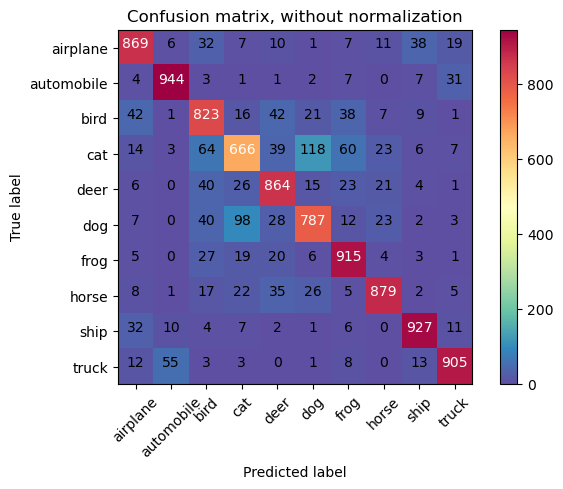

In [17]:
tflite_interpreter = tf.lite.Interpreter("model_10_VGG15_Base_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_VGG15_Base_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [18]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG12_Base_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=200,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 dropout_24 (Dropout)        (None, 32, 32, 16)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_55 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

                                                                 
 quant_dropout_29 (QuantizeW  (None, 128)              1         
 rapperV2)                                                       
                                                                 
 quant_dense_9 (QuantizeWrap  (None, 10)               1295      
 perV2)                                                          
                                                                 
Total params: 657,168
Trainable params: 655,642
Non-trainable params: 1,526
_________________________________________________________________


/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
781/781 [==============================] - 21s 25ms/step - loss: 2.3043 - accuracy: 0.1252 - val_loss: 2.2146 - val_accuracy: 0.2022
Epoch 2/200
781/781 [==============================] - 20s 25ms/step - loss: 2.1503 - accuracy: 0.1952 - val_loss: 2.0920 - val_accuracy: 0.2341
Epoch 3/200
781/781 [==============================] - 19s 25ms/step - loss: 2.0300 - accuracy: 0.2213 - val_loss: 2.0267 - val_accuracy: 0.2298
Epoch 4/200
781/781 [==============================] - 20s 25ms/step - loss: 1.8813 - accuracy: 0.2692 - val_loss: 1.8381 - val_accuracy: 0.2966
Epoch 5/200
781/781 [==============================] - 20s 25ms/step - loss: 1.7871 - accuracy: 0.3052 - val_loss: 1.7669 - val_accuracy: 0.3182
Epoch 6/200
781/781 [==============================] - 20s 25ms/step - loss: 1.7187 - accuracy: 0.3330 - val_loss: 1.6068 - val_accuracy: 0.3890
Epoch 7/200
781/781 [==============================] - 20s 25ms/step - loss: 1.6683 - accuracy: 0.3542 - val_loss: 1.6628 - val_ac

781/781 [==============================] - 20s 25ms/step - loss: 0.7570 - accuracy: 0.7373 - val_loss: 0.6988 - val_accuracy: 0.7598
Epoch 58/200
781/781 [==============================] - 20s 25ms/step - loss: 0.7599 - accuracy: 0.7385 - val_loss: 0.7122 - val_accuracy: 0.7578
Epoch 59/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7540 - accuracy: 0.7390 - val_loss: 0.7002 - val_accuracy: 0.7646
Epoch 60/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7400 - accuracy: 0.7435 - val_loss: 0.6740 - val_accuracy: 0.7647
Epoch 61/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7386 - accuracy: 0.7455 - val_loss: 0.6786 - val_accuracy: 0.7655
Epoch 62/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7278 - accuracy: 0.7474 - val_loss: 0.6672 - val_accuracy: 0.7725
Epoch 63/200
781/781 [==============================] - 19s 25ms/step - loss: 0.7126 - accuracy: 0.7546 - val_loss: 0.6752 - val_accuracy

781/781 [==============================] - 19s 25ms/step - loss: 0.4909 - accuracy: 0.8318 - val_loss: 0.5315 - val_accuracy: 0.8264
Epoch 114/200
781/781 [==============================] - 19s 25ms/step - loss: 0.4925 - accuracy: 0.8323 - val_loss: 0.5318 - val_accuracy: 0.8268
Epoch 115/200
781/781 [==============================] - 20s 25ms/step - loss: 0.4878 - accuracy: 0.8334 - val_loss: 0.5352 - val_accuracy: 0.8263
Epoch 116/200
781/781 [==============================] - 20s 25ms/step - loss: 0.4842 - accuracy: 0.8351 - val_loss: 0.5845 - val_accuracy: 0.8141
Epoch 117/200
781/781 [==============================] - 20s 25ms/step - loss: 0.4813 - accuracy: 0.8355 - val_loss: 0.5224 - val_accuracy: 0.8263
Epoch 118/200
781/781 [==============================] - 20s 25ms/step - loss: 0.4805 - accuracy: 0.8365 - val_loss: 0.5488 - val_accuracy: 0.8268
Epoch 119/200
781/781 [==============================] - 19s 25ms/step - loss: 0.4856 - accuracy: 0.8331 - val_loss: 0.5350 - val_ac

Epoch 169/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3719 - accuracy: 0.8738 - val_loss: 0.4995 - val_accuracy: 0.8455
Epoch 170/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3707 - accuracy: 0.8729 - val_loss: 0.5032 - val_accuracy: 0.8460
Epoch 171/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3730 - accuracy: 0.8723 - val_loss: 0.4967 - val_accuracy: 0.8458
Epoch 172/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3650 - accuracy: 0.8745 - val_loss: 0.4986 - val_accuracy: 0.8473
Epoch 173/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3662 - accuracy: 0.8748 - val_loss: 0.5112 - val_accuracy: 0.8412
Epoch 174/200
781/781 [==============================] - 20s 25ms/step - loss: 0.3700 - accuracy: 0.8725 - val_loss: 0.5016 - val_accuracy: 0.8476
Epoch 175/200
781/781 [==============================] - 19s 25ms/step - loss: 0.3643 - accuracy: 0.8769 - val_loss: 0

781/781 [==============================] - 5s 7ms/step - loss: 0.3319 - accuracy: 0.8858 - val_loss: 0.4980 - val_accuracy: 0.8513


In [19]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_VGG12_Base_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.49800658226013184
Quantization aware training accuracy:  0.8513000011444092


INFO:tensorflow:Assets written to: /tmp/tmpo2mziuqo/assets


INFO:tensorflow:Assets written to: /tmp/tmpo2mziuqo/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 04:54:05.148512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 04:54:05.148538: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 04:54:05.148685: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo2mziuqo
2023-06-06 04:54:05.156395: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 04:54:05.156413: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo2mziuqo
2023-06-06 04:54:05.180556: I tensorflow/

687232

In [20]:
c_model_name = 'cifar10_vgg12_base_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_52_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_VGG12_Base_QAT.tflite is 85.26%
Confusion matrix, without normalization
[[854  15  21  14  10   1   9   2  47  27]
 [  4 936   0   2   0   1   2   0  10  45]
 [ 42   1 759  35  55  30  63   7   6   2]
 [ 10   4  31 710  44  98  72  15   4  12]
 [  9   1  32  30 847  16  40  22   2   1]
 [  4   3  19 129  30 776  20  17   0   2]
 [  3   1  18  20  14   7 935   1   1   0]
 [ 10   2  15  34  29  25   6 874   1   4]
 [ 31  13   4  10   2   0   6   1 917  16]
 [  7  44   4   5   2   0   4   2  14 918]]


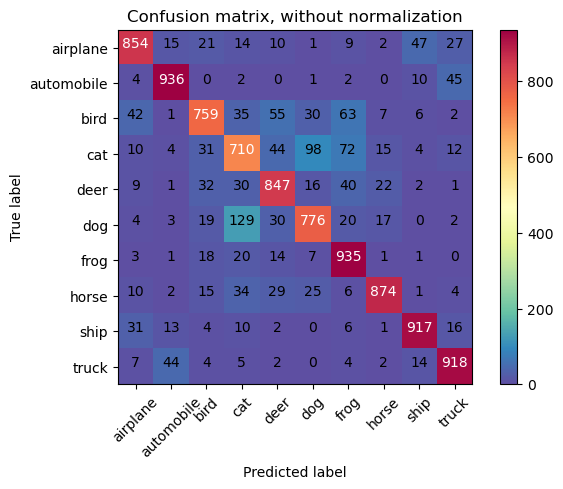

In [21]:
tflite_interpreter = tf.lite.Interpreter("model_10_VGG12_Base_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_VGG12_Base_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [26]:
model_10 = Sequential()
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_VGG8_Base_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=200,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_87 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_88 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_89 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

781/781 [==============================] - 13s 17ms/step - loss: 1.2485 - accuracy: 0.5495 - val_loss: 1.1021 - val_accuracy: 0.6092
Epoch 13/200
781/781 [==============================] - 13s 17ms/step - loss: 1.2092 - accuracy: 0.5645 - val_loss: 1.0756 - val_accuracy: 0.6127
Epoch 14/200
781/781 [==============================] - 13s 17ms/step - loss: 1.1886 - accuracy: 0.5734 - val_loss: 1.0767 - val_accuracy: 0.6134
Epoch 15/200
781/781 [==============================] - 13s 17ms/step - loss: 1.1531 - accuracy: 0.5855 - val_loss: 1.0137 - val_accuracy: 0.6409
Epoch 16/200
781/781 [==============================] - 13s 17ms/step - loss: 1.1320 - accuracy: 0.5945 - val_loss: 1.0552 - val_accuracy: 0.6211
Epoch 17/200
781/781 [==============================] - 13s 16ms/step - loss: 1.1022 - accuracy: 0.6051 - val_loss: 0.9695 - val_accuracy: 0.6551
Epoch 18/200
781/781 [==============================] - 13s 16ms/step - loss: 1.0926 - accuracy: 0.6102 - val_loss: 0.9809 - val_accuracy

781/781 [==============================] - 13s 17ms/step - loss: 0.6117 - accuracy: 0.7889 - val_loss: 0.5701 - val_accuracy: 0.8066
Epoch 69/200
781/781 [==============================] - 13s 17ms/step - loss: 0.6088 - accuracy: 0.7909 - val_loss: 0.5659 - val_accuracy: 0.8085
Epoch 70/200
781/781 [==============================] - 13s 17ms/step - loss: 0.6049 - accuracy: 0.7912 - val_loss: 0.5878 - val_accuracy: 0.7977
Epoch 71/200
781/781 [==============================] - 13s 17ms/step - loss: 0.5937 - accuracy: 0.7951 - val_loss: 0.5903 - val_accuracy: 0.7940
Epoch 72/200
781/781 [==============================] - 13s 17ms/step - loss: 0.5900 - accuracy: 0.7944 - val_loss: 0.5550 - val_accuracy: 0.8103
Epoch 73/200
781/781 [==============================] - 13s 17ms/step - loss: 0.5905 - accuracy: 0.7942 - val_loss: 0.5658 - val_accuracy: 0.8050
Epoch 74/200
781/781 [==============================] - 13s 17ms/step - loss: 0.5911 - accuracy: 0.7953 - val_loss: 0.5562 - val_accuracy

781/781 [==============================] - 13s 16ms/step - loss: 0.4301 - accuracy: 0.8470 - val_loss: 0.5067 - val_accuracy: 0.8329
Epoch 125/200
781/781 [==============================] - 13s 16ms/step - loss: 0.4327 - accuracy: 0.8493 - val_loss: 0.4826 - val_accuracy: 0.8397
Epoch 126/200
781/781 [==============================] - 13s 16ms/step - loss: 0.4284 - accuracy: 0.8497 - val_loss: 0.4861 - val_accuracy: 0.8400
Epoch 127/200
781/781 [==============================] - 13s 17ms/step - loss: 0.4235 - accuracy: 0.8514 - val_loss: 0.4865 - val_accuracy: 0.8400
Epoch 128/200
781/781 [==============================] - 13s 17ms/step - loss: 0.4233 - accuracy: 0.8526 - val_loss: 0.4906 - val_accuracy: 0.8377
Epoch 129/200
781/781 [==============================] - 13s 17ms/step - loss: 0.4243 - accuracy: 0.8503 - val_loss: 0.5143 - val_accuracy: 0.8345
Epoch 130/200
781/781 [==============================] - 13s 17ms/step - loss: 0.4175 - accuracy: 0.8535 - val_loss: 0.4885 - val_ac

Epoch 180/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3337 - accuracy: 0.8810 - val_loss: 0.4827 - val_accuracy: 0.8519
Epoch 181/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3357 - accuracy: 0.8815 - val_loss: 0.5077 - val_accuracy: 0.8418
Epoch 182/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3371 - accuracy: 0.8811 - val_loss: 0.4673 - val_accuracy: 0.8567
Epoch 183/200
781/781 [==============================] - 13s 16ms/step - loss: 0.3261 - accuracy: 0.8860 - val_loss: 0.4783 - val_accuracy: 0.8526
Epoch 184/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3291 - accuracy: 0.8820 - val_loss: 0.4683 - val_accuracy: 0.8546
Epoch 185/200
781/781 [==============================] - 13s 17ms/step - loss: 0.3290 - accuracy: 0.8842 - val_loss: 0.4733 - val_accuracy: 0.8541
Epoch 186/200
781/781 [==============================] - 13s 16ms/step - loss: 0.3281 - accuracy: 0.8844 - val_loss: 0

781/781 [==============================] - 4s 5ms/step - loss: 0.3136 - accuracy: 0.8877 - val_loss: 0.4779 - val_accuracy: 0.8529


In [27]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_VGG8_Base_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.47787293791770935
Quantization aware training accuracy:  0.8529000282287598


INFO:tensorflow:Assets written to: /tmp/tmpxouj9c9j/assets


INFO:tensorflow:Assets written to: /tmp/tmpxouj9c9j/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 10:22:15.988369: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 10:22:15.988400: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 10:22:15.988549: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxouj9c9j
2023-06-06 10:22:15.995048: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 10:22:15.995073: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxouj9c9j
2023-06-06 10:22:16.015404: I tensorflow/

571288

In [28]:
c_model_name = 'cifar10_vgg8_base_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_86_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_VGG8_Base_QAT.tflite is 85.28999999999999%
Confusion matrix, without normalization
[[859  12  25  11   8   0   6   5  48  26]
 [  4 940   1   1   0   2   5   0  14  33]
 [ 48   0 782  35  43  40  39   7   5   1]
 [ 12   3  40 714  36 116  51  12  10   6]
 [  7   1  36  36 847  15  33  21   4   0]
 [  8   1  27 117  24 792  10  19   1   1]
 [  4   2  24  32  17  11 904   1   2   3]
 [  6   2   9  28  51  44   5 850   0   5]
 [ 32  14   1   8   2   1   4   1 927  10]
 [  7  47   2   6   0   0   3   3  18 914]]


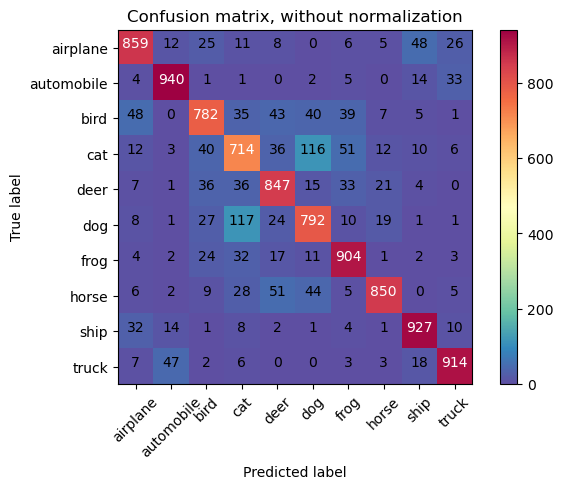

In [29]:
tflite_interpreter = tf.lite.Interpreter("model_10_VGG8_Base_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_VGG8_Base_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [34]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_A_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=200,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_122 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 dropout_68 (Dropout)        (None, 16, 16, 16)        0         
                                                                 
 conv2d_123 (Conv2D)         (None, 16, 16, 32)        4640      
                                                                 
 conv2d_124 (Conv2D)         (None, 16, 16, 32)        9248      
                                                     

/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
781/781 [==============================] - 16s 19ms/step - loss: 2.3014 - accuracy: 0.1320 - val_loss: 2.1712 - val_accuracy: 0.1913
Epoch 2/200
781/781 [==============================] - 14s 18ms/step - loss: 2.1093 - accuracy: 0.1869 - val_loss: 2.0376 - val_accuracy: 0.2104
Epoch 3/200
781/781 [==============================] - 14s 18ms/step - loss: 1.9787 - accuracy: 0.2083 - val_loss: 1.8900 - val_accuracy: 0.2541
Epoch 4/200
781/781 [==============================] - 14s 18ms/step - loss: 1.9137 - accuracy: 0.2362 - val_loss: 1.8391 - val_accuracy: 0.2938
Epoch 5/200
781/781 [==============================] - 14s 19ms/step - loss: 1.8368 - accuracy: 0.2808 - val_loss: 1.7272 - val_accuracy: 0.3472
Epoch 6/200
781/781 [==============================] - 14s 18ms/step - loss: 1.7661 - accuracy: 0.3152 - val_loss: 1.6639 - val_accuracy: 0.3638
Epoch 7/200
781/781 [==============================] - 15s 19ms/step - loss: 1.7217 - accuracy: 0.3356 - val_loss: 1.6342 - val_ac

781/781 [==============================] - 14s 18ms/step - loss: 0.9582 - accuracy: 0.6645 - val_loss: 0.8359 - val_accuracy: 0.7008
Epoch 58/200
781/781 [==============================] - 14s 18ms/step - loss: 0.9522 - accuracy: 0.6640 - val_loss: 0.8716 - val_accuracy: 0.6900
Epoch 59/200
781/781 [==============================] - 14s 18ms/step - loss: 0.9471 - accuracy: 0.6684 - val_loss: 0.8276 - val_accuracy: 0.7058
Epoch 60/200
781/781 [==============================] - 14s 18ms/step - loss: 0.9331 - accuracy: 0.6730 - val_loss: 0.8280 - val_accuracy: 0.7062
Epoch 61/200
781/781 [==============================] - 14s 18ms/step - loss: 0.9384 - accuracy: 0.6689 - val_loss: 0.8411 - val_accuracy: 0.7024
Epoch 62/200
781/781 [==============================] - 14s 18ms/step - loss: 0.9366 - accuracy: 0.6740 - val_loss: 0.8133 - val_accuracy: 0.7115
Epoch 63/200
781/781 [==============================] - 14s 18ms/step - loss: 0.9230 - accuracy: 0.6787 - val_loss: 0.8176 - val_accuracy

781/781 [==============================] - 14s 18ms/step - loss: 0.7450 - accuracy: 0.7431 - val_loss: 0.6668 - val_accuracy: 0.7723
Epoch 114/200
781/781 [==============================] - 14s 18ms/step - loss: 0.7391 - accuracy: 0.7433 - val_loss: 0.6653 - val_accuracy: 0.7737
Epoch 115/200
781/781 [==============================] - 14s 18ms/step - loss: 0.7423 - accuracy: 0.7455 - val_loss: 0.6835 - val_accuracy: 0.7648
Epoch 116/200
781/781 [==============================] - 14s 18ms/step - loss: 0.7358 - accuracy: 0.7475 - val_loss: 0.6696 - val_accuracy: 0.7728
Epoch 117/200
781/781 [==============================] - 14s 18ms/step - loss: 0.7349 - accuracy: 0.7466 - val_loss: 0.6766 - val_accuracy: 0.7701
Epoch 118/200
781/781 [==============================] - 14s 18ms/step - loss: 0.7372 - accuracy: 0.7475 - val_loss: 0.6637 - val_accuracy: 0.7702
Epoch 119/200
781/781 [==============================] - 14s 18ms/step - loss: 0.7332 - accuracy: 0.7468 - val_loss: 0.6547 - val_ac

Epoch 169/200
781/781 [==============================] - 14s 18ms/step - loss: 0.6388 - accuracy: 0.7811 - val_loss: 0.5886 - val_accuracy: 0.8012
Epoch 170/200
781/781 [==============================] - 14s 19ms/step - loss: 0.6332 - accuracy: 0.7814 - val_loss: 0.6098 - val_accuracy: 0.7943
Epoch 171/200
781/781 [==============================] - 14s 18ms/step - loss: 0.6335 - accuracy: 0.7829 - val_loss: 0.5959 - val_accuracy: 0.8016
Epoch 172/200
781/781 [==============================] - 14s 18ms/step - loss: 0.6340 - accuracy: 0.7840 - val_loss: 0.6298 - val_accuracy: 0.7872
Epoch 173/200
781/781 [==============================] - 14s 18ms/step - loss: 0.6288 - accuracy: 0.7841 - val_loss: 0.5844 - val_accuracy: 0.8019
Epoch 174/200
781/781 [==============================] - 14s 18ms/step - loss: 0.6289 - accuracy: 0.7845 - val_loss: 0.5826 - val_accuracy: 0.8038
Epoch 175/200
781/781 [==============================] - 14s 18ms/step - loss: 0.6287 - accuracy: 0.7837 - val_loss: 0

781/781 [==============================] - 4s 5ms/step - loss: 0.5960 - accuracy: 0.7996 - val_loss: 0.5730 - val_accuracy: 0.8086


In [35]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_A_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.5729549527168274
Quantization aware training accuracy:  0.8086000084877014


INFO:tensorflow:Assets written to: /tmp/tmpjctlto55/assets


INFO:tensorflow:Assets written to: /tmp/tmpjctlto55/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 11:22:06.667428: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 11:22:06.667463: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 11:22:06.667607: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjctlto55
2023-06-06 11:22:06.674593: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 11:22:06.674611: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjctlto55
2023-06-06 11:22:06.702606: I tensorflow/

383928

In [36]:
c_model_name = 'cifar10_reduced_a_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_121_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_A_QAT.tflite is 80.81%
Confusion matrix, without normalization
[[836  18  18  18  20   2   8   9  46  25]
 [  4 939   0   2   0   2   2   0   7  44]
 [ 68   5 588  59 107  65  72  24   7   5]
 [ 14   7  26 662  53 143  56  24   7   8]
 [  8   1  20  45 852  14  26  30   3   1]
 [  9   5  11 170  42 705  16  34   2   6]
 [  7   1  19  47  30  13 877   2   3   1]
 [ 10   3   7  31  62  39   4 837   2   5]
 [ 47  23   2   9   6   1   5   3 889  15]
 [ 17  53   2   8   3   2   1   4  14 896]]


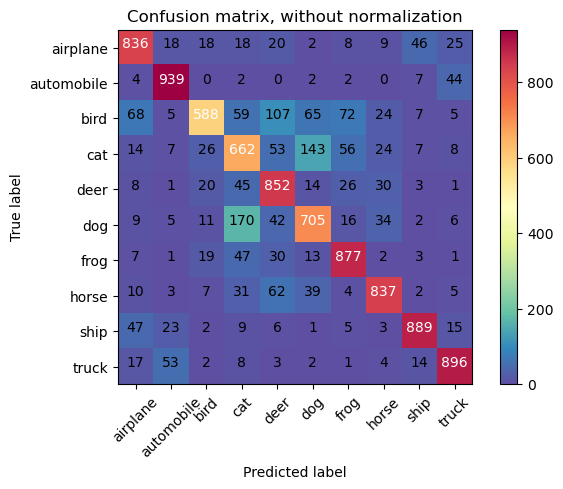

In [37]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_A_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_A_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [78]:
model_10 = Sequential()
model_10.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((4, 4)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_B_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=200,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_403 (Conv2D)         (None, 32, 32, 8)         224       
                                                                 
 conv2d_404 (Conv2D)         (None, 32, 32, 16)        1168      
                                                                 
 conv2d_405 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_196 (MaxPooli  (None, 8, 8, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_269 (Dropout)       (None, 8, 8, 32)          0         
                                                                 
 conv2d_406 (Conv2D)         (None, 8, 8, 64)          18496     
                                                     

/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
781/781 [==============================] - 13s 15ms/step - loss: 2.2712 - accuracy: 0.1486 - val_loss: 2.0984 - val_accuracy: 0.2348
Epoch 2/200
781/781 [==============================] - 11s 15ms/step - loss: 2.0440 - accuracy: 0.2185 - val_loss: 1.8703 - val_accuracy: 0.3075
Epoch 3/200
781/781 [==============================] - 12s 15ms/step - loss: 1.8924 - accuracy: 0.2677 - val_loss: 1.7421 - val_accuracy: 0.3645
Epoch 4/200
781/781 [==============================] - 12s 15ms/step - loss: 1.7856 - accuracy: 0.3159 - val_loss: 1.6367 - val_accuracy: 0.3965
Epoch 5/200
781/781 [==============================] - 12s 15ms/step - loss: 1.7093 - accuracy: 0.3481 - val_loss: 1.5520 - val_accuracy: 0.4287
Epoch 6/200
781/781 [==============================] - 12s 15ms/step - loss: 1.6520 - accuracy: 0.3748 - val_loss: 1.5437 - val_accuracy: 0.4332
Epoch 7/200
781/781 [==============================] - 12s 15ms/step - loss: 1.6009 - accuracy: 0.3984 - val_loss: 1.4710 - val_ac

781/781 [==============================] - 12s 15ms/step - loss: 0.8817 - accuracy: 0.6924 - val_loss: 0.8121 - val_accuracy: 0.7161
Epoch 58/200
781/781 [==============================] - 12s 15ms/step - loss: 0.8824 - accuracy: 0.6940 - val_loss: 0.7717 - val_accuracy: 0.7325
Epoch 59/200
781/781 [==============================] - 12s 15ms/step - loss: 0.8685 - accuracy: 0.6958 - val_loss: 0.7677 - val_accuracy: 0.7308
Epoch 60/200
781/781 [==============================] - 12s 15ms/step - loss: 0.8751 - accuracy: 0.6982 - val_loss: 0.7698 - val_accuracy: 0.7297
Epoch 61/200
781/781 [==============================] - 12s 15ms/step - loss: 0.8570 - accuracy: 0.7027 - val_loss: 0.7575 - val_accuracy: 0.7372
Epoch 62/200
781/781 [==============================] - 11s 15ms/step - loss: 0.8576 - accuracy: 0.7029 - val_loss: 0.7682 - val_accuracy: 0.7328
Epoch 63/200
781/781 [==============================] - 12s 15ms/step - loss: 0.8566 - accuracy: 0.7020 - val_loss: 0.7578 - val_accuracy

781/781 [==============================] - 12s 15ms/step - loss: 0.6843 - accuracy: 0.7631 - val_loss: 0.6439 - val_accuracy: 0.7797
Epoch 114/200
781/781 [==============================] - 12s 15ms/step - loss: 0.6718 - accuracy: 0.7665 - val_loss: 0.6473 - val_accuracy: 0.7788
Epoch 115/200
781/781 [==============================] - 12s 15ms/step - loss: 0.6764 - accuracy: 0.7658 - val_loss: 0.6384 - val_accuracy: 0.7809
Epoch 116/200
781/781 [==============================] - 12s 15ms/step - loss: 0.6789 - accuracy: 0.7669 - val_loss: 0.6460 - val_accuracy: 0.7752
Epoch 117/200
781/781 [==============================] - 12s 15ms/step - loss: 0.6718 - accuracy: 0.7666 - val_loss: 0.6533 - val_accuracy: 0.7781
Epoch 118/200
781/781 [==============================] - 11s 15ms/step - loss: 0.6758 - accuracy: 0.7668 - val_loss: 0.6446 - val_accuracy: 0.7787
Epoch 119/200
781/781 [==============================] - 12s 15ms/step - loss: 0.6712 - accuracy: 0.7674 - val_loss: 0.6458 - val_ac

Epoch 169/200
781/781 [==============================] - 12s 15ms/step - loss: 0.5788 - accuracy: 0.7988 - val_loss: 0.6281 - val_accuracy: 0.7907
Epoch 170/200
781/781 [==============================] - 12s 15ms/step - loss: 0.5723 - accuracy: 0.7997 - val_loss: 0.6164 - val_accuracy: 0.7959
Epoch 171/200
781/781 [==============================] - 12s 15ms/step - loss: 0.5755 - accuracy: 0.7995 - val_loss: 0.6181 - val_accuracy: 0.7939
Epoch 172/200
781/781 [==============================] - 12s 15ms/step - loss: 0.5834 - accuracy: 0.7974 - val_loss: 0.6240 - val_accuracy: 0.7908
Epoch 173/200
781/781 [==============================] - 12s 15ms/step - loss: 0.5747 - accuracy: 0.8019 - val_loss: 0.6077 - val_accuracy: 0.7940
Epoch 174/200
781/781 [==============================] - 12s 15ms/step - loss: 0.5752 - accuracy: 0.8007 - val_loss: 0.6000 - val_accuracy: 0.7965
Epoch 175/200
781/781 [==============================] - 12s 15ms/step - loss: 0.5772 - accuracy: 0.7998 - val_loss: 0

781/781 [==============================] - 3s 4ms/step - loss: 0.5497 - accuracy: 0.8087 - val_loss: 0.6019 - val_accuracy: 0.7991


In [79]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_B_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.6018643379211426
Quantization aware training accuracy:  0.7990999817848206


INFO:tensorflow:Assets written to: /tmp/tmp_snjh8ya/assets


INFO:tensorflow:Assets written to: /tmp/tmp_snjh8ya/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 12:27:53.062695: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 12:27:53.062727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 12:27:53.062882: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_snjh8ya
2023-06-06 12:27:53.069739: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 12:27:53.069766: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_snjh8ya
2023-06-06 12:27:53.088047: I tensorflow/

331792

In [80]:
c_model_name = 'cifar10_reduced_b_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_403_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_B_QAT.tflite is 79.88%
Confusion matrix, without normalization
[[815  15  37  13  15   0   8   2  66  29]
 [  8 907   1   4   1   1   8   1  17  52]
 [ 61   1 679  40  68  31  79  21  14   6]
 [ 15   4  49 623  59 111  91  24  15   9]
 [  6   1  44  31 803  10  62  31   8   4]
 [  7   3  49 179  51 638  33  33   1   6]
 [  5   2  34  34  17   5 901   0   2   0]
 [ 11   2  24  29  41  50  10 821   4   8]
 [ 31  16   7   6   2   1   6   2 917  12]
 [ 14  59   4   4   2   1   5   5  22 884]]


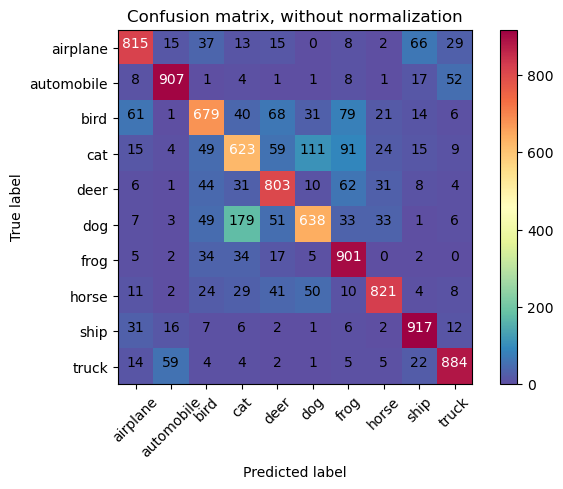

In [81]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_B_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_B_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [82]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_C_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=200,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_409 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_410 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 conv2d_411 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_199 (MaxPooli  (None, 16, 16, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_273 (Dropout)       (None, 16, 16, 16)        0         
                                                                 
 conv2d_412 (Conv2D)         (None, 16, 16, 32)        4640      
                                                     

 apperV2)                                                        
                                                                 
Total params: 262,367
Trainable params: 261,386
Non-trainable params: 981
_________________________________________________________________


/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
781/781 [==============================] - 17s 20ms/step - loss: 2.3121 - accuracy: 0.1054 - val_loss: 2.2979 - val_accuracy: 0.1323
Epoch 2/200
781/781 [==============================] - 15s 20ms/step - loss: 2.2360 - accuracy: 0.1513 - val_loss: 2.1092 - val_accuracy: 0.1947
Epoch 3/200
781/781 [==============================] - 15s 19ms/step - loss: 2.0789 - accuracy: 0.1845 - val_loss: 1.9643 - val_accuracy: 0.2165
Epoch 4/200
781/781 [==============================] - 15s 20ms/step - loss: 1.9929 - accuracy: 0.1982 - val_loss: 1.9034 - val_accuracy: 0.2255
Epoch 5/200
781/781 [==============================] - 15s 19ms/step - loss: 1.9246 - accuracy: 0.2196 - val_loss: 1.8304 - val_accuracy: 0.2811
Epoch 6/200
781/781 [==============================] - 15s 19ms/step - loss: 1.8751 - accuracy: 0.2521 - val_loss: 1.7761 - val_accuracy: 0.3107
Epoch 7/200
781/781 [==============================] - 15s 19ms/step - loss: 1.8110 - accuracy: 0.2826 - val_loss: 1.7580 - val_ac

781/781 [==============================] - 15s 20ms/step - loss: 0.8977 - accuracy: 0.6855 - val_loss: 0.8763 - val_accuracy: 0.6917
Epoch 58/200
781/781 [==============================] - 15s 19ms/step - loss: 0.8973 - accuracy: 0.6853 - val_loss: 0.8374 - val_accuracy: 0.7104
Epoch 59/200
781/781 [==============================] - 15s 19ms/step - loss: 0.8929 - accuracy: 0.6851 - val_loss: 0.8530 - val_accuracy: 0.7050
Epoch 60/200
781/781 [==============================] - 15s 19ms/step - loss: 0.8854 - accuracy: 0.6901 - val_loss: 0.8121 - val_accuracy: 0.7142
Epoch 61/200
781/781 [==============================] - 15s 20ms/step - loss: 0.8802 - accuracy: 0.6919 - val_loss: 0.8347 - val_accuracy: 0.7005
Epoch 62/200
781/781 [==============================] - 15s 19ms/step - loss: 0.8723 - accuracy: 0.6916 - val_loss: 0.7969 - val_accuracy: 0.7180
Epoch 63/200
781/781 [==============================] - 15s 20ms/step - loss: 0.8652 - accuracy: 0.6981 - val_loss: 0.8247 - val_accuracy

781/781 [==============================] - 15s 19ms/step - loss: 0.6754 - accuracy: 0.7695 - val_loss: 0.6533 - val_accuracy: 0.7743
Epoch 114/200
781/781 [==============================] - 15s 19ms/step - loss: 0.6709 - accuracy: 0.7712 - val_loss: 0.6551 - val_accuracy: 0.7733
Epoch 115/200
781/781 [==============================] - 15s 19ms/step - loss: 0.6713 - accuracy: 0.7692 - val_loss: 0.6416 - val_accuracy: 0.7789
Epoch 116/200
781/781 [==============================] - 15s 19ms/step - loss: 0.6665 - accuracy: 0.7702 - val_loss: 0.6935 - val_accuracy: 0.7624
Epoch 117/200
781/781 [==============================] - 15s 19ms/step - loss: 0.6638 - accuracy: 0.7717 - val_loss: 0.6536 - val_accuracy: 0.7727
Epoch 118/200
781/781 [==============================] - 15s 19ms/step - loss: 0.6587 - accuracy: 0.7731 - val_loss: 0.6682 - val_accuracy: 0.7708
Epoch 119/200
781/781 [==============================] - 15s 19ms/step - loss: 0.6576 - accuracy: 0.7745 - val_loss: 0.6802 - val_ac

Epoch 169/200
781/781 [==============================] - 15s 19ms/step - loss: 0.5628 - accuracy: 0.8084 - val_loss: 0.6072 - val_accuracy: 0.7953
Epoch 170/200
781/781 [==============================] - 15s 19ms/step - loss: 0.5640 - accuracy: 0.8054 - val_loss: 0.6077 - val_accuracy: 0.7947
Epoch 171/200
781/781 [==============================] - 15s 19ms/step - loss: 0.5544 - accuracy: 0.8121 - val_loss: 0.5851 - val_accuracy: 0.8024
Epoch 172/200
781/781 [==============================] - 15s 19ms/step - loss: 0.5572 - accuracy: 0.8076 - val_loss: 0.5902 - val_accuracy: 0.7978
Epoch 173/200
781/781 [==============================] - 15s 19ms/step - loss: 0.5561 - accuracy: 0.8098 - val_loss: 0.5933 - val_accuracy: 0.8025
Epoch 174/200
781/781 [==============================] - 15s 19ms/step - loss: 0.5553 - accuracy: 0.8095 - val_loss: 0.5795 - val_accuracy: 0.8023
Epoch 175/200
781/781 [==============================] - 15s 19ms/step - loss: 0.5496 - accuracy: 0.8115 - val_loss: 0

781/781 [==============================] - 4s 5ms/step - loss: 0.5290 - accuracy: 0.8195 - val_loss: 0.5727 - val_accuracy: 0.8054


In [83]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_C_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.5727153420448303
Quantization aware training accuracy:  0.805400013923645


INFO:tensorflow:Assets written to: /tmp/tmpliohsgda/assets


INFO:tensorflow:Assets written to: /tmp/tmpliohsgda/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 13:17:47.481003: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 13:17:47.481033: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 13:17:47.481188: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpliohsgda
2023-06-06 13:17:47.490631: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 13:17:47.490657: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpliohsgda
2023-06-06 13:17:47.525385: I tensorflow/

285920

In [84]:
c_model_name = 'cifar10_reduced_c_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_409_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_C_QAT.tflite is 80.54%
Confusion matrix, without normalization
[[833  11  37  22  12   0   9   8  51  17]
 [  8 921   1   4   3   1   5   2  18  37]
 [ 51   2 688  42  60  48  92  10   5   2]
 [ 21   5  64 640  44 122  78  18   5   3]
 [ 11   0  48  51 786  10  68  24   1   1]
 [  5   3  35 192  28 672  33  31   1   0]
 [  7   0  27  31  11   7 914   0   3   0]
 [  9   3  25  44  41  42   9 823   3   1]
 [ 43  11   6  18   3   0   9   1 903   6]
 [ 22  47   3  18   2   0  10   7  17 874]]


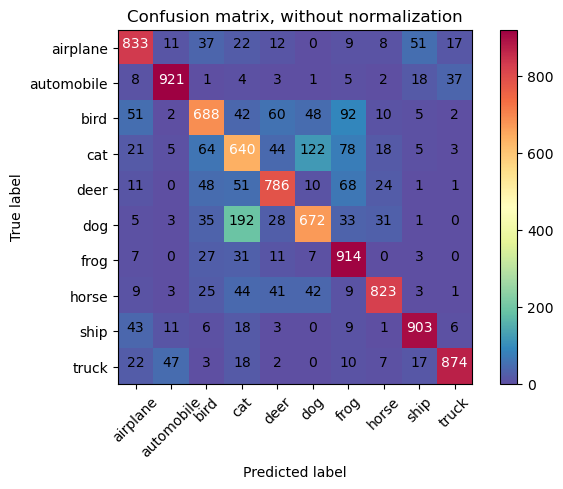

In [85]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_C_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_C_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [90]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_D_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, steps_per_epoch=steps,epochs=200,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_453 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_454 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_219 (MaxPooli  (None, 16, 16, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_298 (Dropout)       (None, 16, 16, 16)        0         
                                                                 
 conv2d_455 (Conv2D)         (None, 16, 16, 32)        4640      
                                                                 
 conv2d_456 (Conv2D)         (None, 16, 16, 32)        9248      
                                                     

/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
781/781 [==============================] - 13s 15ms/step - loss: 2.2882 - accuracy: 0.1302 - val_loss: 2.2543 - val_accuracy: 0.1670
Epoch 2/200
781/781 [==============================] - 12s 15ms/step - loss: 2.1342 - accuracy: 0.1866 - val_loss: 2.1555 - val_accuracy: 0.1850
Epoch 3/200
781/781 [==============================] - 12s 15ms/step - loss: 2.0137 - accuracy: 0.2090 - val_loss: 1.9918 - val_accuracy: 0.2406
Epoch 4/200
781/781 [==============================] - 12s 15ms/step - loss: 1.9274 - accuracy: 0.2381 - val_loss: 2.0034 - val_accuracy: 0.2508
Epoch 5/200
781/781 [==============================] - 11s 15ms/step - loss: 1.8706 - accuracy: 0.2685 - val_loss: 1.8662 - val_accuracy: 0.2957
Epoch 6/200
781/781 [==============================] - 12s 15ms/step - loss: 1.8269 - accuracy: 0.2847 - val_loss: 1.9095 - val_accuracy: 0.2855
Epoch 7/200
781/781 [==============================] - 12s 15ms/step - loss: 1.7907 - accuracy: 0.3021 - val_loss: 1.7884 - val_ac

781/781 [==============================] - 12s 15ms/step - loss: 1.0250 - accuracy: 0.6362 - val_loss: 0.9553 - val_accuracy: 0.6639
Epoch 58/200
781/781 [==============================] - 12s 15ms/step - loss: 1.0155 - accuracy: 0.6397 - val_loss: 0.9010 - val_accuracy: 0.6779
Epoch 59/200
781/781 [==============================] - 12s 15ms/step - loss: 1.0014 - accuracy: 0.6470 - val_loss: 0.9345 - val_accuracy: 0.6723
Epoch 60/200
781/781 [==============================] - 11s 15ms/step - loss: 0.9971 - accuracy: 0.6454 - val_loss: 0.8863 - val_accuracy: 0.6858
Epoch 61/200
781/781 [==============================] - 12s 15ms/step - loss: 0.9944 - accuracy: 0.6506 - val_loss: 0.8920 - val_accuracy: 0.6885
Epoch 62/200
781/781 [==============================] - 12s 15ms/step - loss: 0.9914 - accuracy: 0.6491 - val_loss: 0.9740 - val_accuracy: 0.6630
Epoch 63/200
781/781 [==============================] - 12s 15ms/step - loss: 0.9813 - accuracy: 0.6518 - val_loss: 0.8702 - val_accuracy

781/781 [==============================] - 12s 15ms/step - loss: 0.7987 - accuracy: 0.7205 - val_loss: 0.7081 - val_accuracy: 0.7575
Epoch 114/200
781/781 [==============================] - 12s 15ms/step - loss: 0.7961 - accuracy: 0.7225 - val_loss: 0.7105 - val_accuracy: 0.7552
Epoch 115/200
781/781 [==============================] - 12s 15ms/step - loss: 0.8002 - accuracy: 0.7228 - val_loss: 0.6925 - val_accuracy: 0.7587
Epoch 116/200
781/781 [==============================] - 12s 15ms/step - loss: 0.7865 - accuracy: 0.7275 - val_loss: 0.6909 - val_accuracy: 0.7619
Epoch 117/200
781/781 [==============================] - 12s 15ms/step - loss: 0.7946 - accuracy: 0.7236 - val_loss: 0.6982 - val_accuracy: 0.7551
Epoch 118/200
781/781 [==============================] - 12s 15ms/step - loss: 0.7800 - accuracy: 0.7299 - val_loss: 0.7108 - val_accuracy: 0.7592
Epoch 119/200
781/781 [==============================] - 12s 15ms/step - loss: 0.7806 - accuracy: 0.7303 - val_loss: 0.7041 - val_ac

In [91]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_D_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

In [92]:
c_model_name = 'cifar10_reduced_d_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_453_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_D_QAT.tflite is 78.72%
Confusion matrix, without normalization
[[772   9  60  11  15   0  12  11  88  22]
 [ 12 901   0   2   0   0  16   0  15  54]
 [ 51   0 687  29  83  31  89  16  12   2]
 [ 18   1  78 559  69 106 111  29  19  10]
 [ 11   2  57  28 808   7  47  34   6   0]
 [  4   2  64 158  60 626  31  47   4   4]
 [  3   3  33  30  13   6 904   4   4   0]
 [  7   1  41  22  68  38  10 804   2   7]
 [ 27  10   8   9   3   2   8   2 921  10]
 [ 21  32   2   9   2   0   5   9  30 890]]


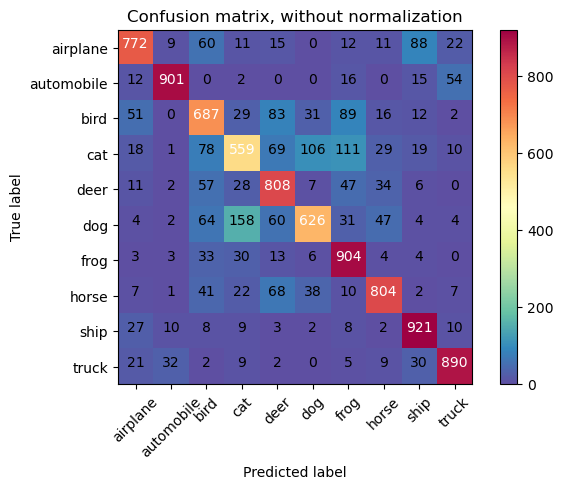

In [26]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_D_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_D_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [34]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_E_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train, y_train, batch_size=64, epochs=400,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_134 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_135 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 dropout_109 (Dropout)       (None, 16, 16, 16)        0         
                                                                 
 conv2d_136 (Conv2D)         (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                

Epoch 10/400
782/782 [==============================] - 9s 11ms/step - loss: 1.7653 - accuracy: 0.3162 - val_loss: 2.2839 - val_accuracy: 0.1822
Epoch 11/400
782/782 [==============================] - 9s 11ms/step - loss: 1.7451 - accuracy: 0.3271 - val_loss: 1.8308 - val_accuracy: 0.3075
Epoch 12/400
782/782 [==============================] - 8s 11ms/step - loss: 1.7186 - accuracy: 0.3369 - val_loss: 1.8416 - val_accuracy: 0.3059
Epoch 13/400
782/782 [==============================] - 8s 11ms/step - loss: 1.6921 - accuracy: 0.3528 - val_loss: 1.9317 - val_accuracy: 0.2788
Epoch 14/400
782/782 [==============================] - 9s 11ms/step - loss: 1.6713 - accuracy: 0.3670 - val_loss: 1.9467 - val_accuracy: 0.2860
Epoch 15/400
782/782 [==============================] - 9s 12ms/step - loss: 1.6539 - accuracy: 0.3696 - val_loss: 2.1209 - val_accuracy: 0.2399
Epoch 16/400
782/782 [==============================] - 9s 11ms/step - loss: 1.6321 - accuracy: 0.3808 - val_loss: 1.9708 - val_ac

782/782 [==============================] - 9s 11ms/step - loss: 1.1691 - accuracy: 0.5796 - val_loss: 1.2044 - val_accuracy: 0.5730
Epoch 67/400
782/782 [==============================] - 9s 11ms/step - loss: 1.1680 - accuracy: 0.5797 - val_loss: 1.1434 - val_accuracy: 0.6053
Epoch 68/400
782/782 [==============================] - 9s 11ms/step - loss: 1.1631 - accuracy: 0.5826 - val_loss: 1.1056 - val_accuracy: 0.6196
Epoch 69/400
782/782 [==============================] - 9s 11ms/step - loss: 1.1565 - accuracy: 0.5833 - val_loss: 1.1653 - val_accuracy: 0.5940
Epoch 70/400
782/782 [==============================] - 9s 11ms/step - loss: 1.1568 - accuracy: 0.5863 - val_loss: 1.1401 - val_accuracy: 0.6075
Epoch 71/400
782/782 [==============================] - 9s 11ms/step - loss: 1.1487 - accuracy: 0.5883 - val_loss: 1.1568 - val_accuracy: 0.5962
Epoch 72/400
782/782 [==============================] - 9s 11ms/step - loss: 1.1444 - accuracy: 0.5906 - val_loss: 1.1511 - val_accuracy: 0.597

782/782 [==============================] - 9s 11ms/step - loss: 1.0082 - accuracy: 0.6421 - val_loss: 1.0102 - val_accuracy: 0.6438
Epoch 123/400
782/782 [==============================] - 9s 11ms/step - loss: 1.0063 - accuracy: 0.6437 - val_loss: 0.9253 - val_accuracy: 0.6692
Epoch 124/400
782/782 [==============================] - 9s 11ms/step - loss: 0.9984 - accuracy: 0.6434 - val_loss: 0.9503 - val_accuracy: 0.6627
Epoch 125/400
782/782 [==============================] - 9s 11ms/step - loss: 1.0026 - accuracy: 0.6459 - val_loss: 0.9494 - val_accuracy: 0.6655
Epoch 126/400
782/782 [==============================] - 9s 11ms/step - loss: 0.9983 - accuracy: 0.6435 - val_loss: 0.9817 - val_accuracy: 0.6457
Epoch 127/400
782/782 [==============================] - 9s 11ms/step - loss: 0.9903 - accuracy: 0.6491 - val_loss: 0.9628 - val_accuracy: 0.6547
Epoch 128/400
782/782 [==============================] - 9s 11ms/step - loss: 0.9978 - accuracy: 0.6445 - val_loss: 0.9954 - val_accuracy:

782/782 [==============================] - 9s 11ms/step - loss: 0.9074 - accuracy: 0.6800 - val_loss: 0.8520 - val_accuracy: 0.6943
Epoch 179/400
782/782 [==============================] - 9s 11ms/step - loss: 0.9099 - accuracy: 0.6805 - val_loss: 0.8233 - val_accuracy: 0.7068
Epoch 180/400
782/782 [==============================] - 9s 11ms/step - loss: 0.9049 - accuracy: 0.6828 - val_loss: 0.8067 - val_accuracy: 0.7125
Epoch 181/400
782/782 [==============================] - 9s 11ms/step - loss: 0.9074 - accuracy: 0.6795 - val_loss: 0.8274 - val_accuracy: 0.6988
Epoch 182/400
782/782 [==============================] - 9s 11ms/step - loss: 0.9114 - accuracy: 0.6801 - val_loss: 0.8807 - val_accuracy: 0.6872
Epoch 183/400
782/782 [==============================] - 8s 11ms/step - loss: 0.8998 - accuracy: 0.6817 - val_loss: 0.8357 - val_accuracy: 0.7005
Epoch 184/400
782/782 [==============================] - 9s 11ms/step - loss: 0.9058 - accuracy: 0.6798 - val_loss: 0.8147 - val_accuracy:

782/782 [==============================] - 9s 11ms/step - loss: 0.8450 - accuracy: 0.7042 - val_loss: 0.7372 - val_accuracy: 0.7371
Epoch 235/400
782/782 [==============================] - 8s 11ms/step - loss: 0.8476 - accuracy: 0.7045 - val_loss: 0.7519 - val_accuracy: 0.7332
Epoch 236/400
782/782 [==============================] - 9s 11ms/step - loss: 0.8443 - accuracy: 0.7031 - val_loss: 0.7983 - val_accuracy: 0.7168
Epoch 237/400
782/782 [==============================] - 9s 11ms/step - loss: 0.8431 - accuracy: 0.7065 - val_loss: 0.7288 - val_accuracy: 0.7420
Epoch 238/400
782/782 [==============================] - 9s 11ms/step - loss: 0.8470 - accuracy: 0.7042 - val_loss: 0.7545 - val_accuracy: 0.7337
Epoch 239/400
782/782 [==============================] - 8s 11ms/step - loss: 0.8388 - accuracy: 0.7064 - val_loss: 0.7314 - val_accuracy: 0.7374
Epoch 240/400
782/782 [==============================] - 9s 11ms/step - loss: 0.8369 - accuracy: 0.7064 - val_loss: 0.7623 - val_accuracy:

782/782 [==============================] - 9s 11ms/step - loss: 0.8038 - accuracy: 0.7199 - val_loss: 0.7230 - val_accuracy: 0.7442
Epoch 291/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7969 - accuracy: 0.7220 - val_loss: 0.7670 - val_accuracy: 0.7286
Epoch 292/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7955 - accuracy: 0.7239 - val_loss: 0.7436 - val_accuracy: 0.7390
Epoch 293/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7921 - accuracy: 0.7238 - val_loss: 0.7138 - val_accuracy: 0.7492
Epoch 294/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7968 - accuracy: 0.7216 - val_loss: 0.7143 - val_accuracy: 0.7487
Epoch 295/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7964 - accuracy: 0.7227 - val_loss: 0.7599 - val_accuracy: 0.7349
Epoch 296/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7934 - accuracy: 0.7229 - val_loss: 0.7271 - val_accuracy:

782/782 [==============================] - 9s 11ms/step - loss: 0.7589 - accuracy: 0.7372 - val_loss: 0.6620 - val_accuracy: 0.7695
Epoch 347/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7579 - accuracy: 0.7355 - val_loss: 0.7130 - val_accuracy: 0.7467
Epoch 348/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7610 - accuracy: 0.7373 - val_loss: 0.6539 - val_accuracy: 0.7692
Epoch 349/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7628 - accuracy: 0.7353 - val_loss: 0.6581 - val_accuracy: 0.7693
Epoch 350/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7568 - accuracy: 0.7373 - val_loss: 0.6652 - val_accuracy: 0.7664
Epoch 351/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7555 - accuracy: 0.7362 - val_loss: 0.6579 - val_accuracy: 0.7686
Epoch 352/400
782/782 [==============================] - 9s 11ms/step - loss: 0.7598 - accuracy: 0.7347 - val_loss: 0.6751 - val_accuracy:

In [35]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_E_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.6441069841384888
Quantization aware training accuracy:  0.7767999768257141


INFO:tensorflow:Assets written to: /tmp/tmp2qcry5np/assets


INFO:tensorflow:Assets written to: /tmp/tmp2qcry5np/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 17:00:23.626807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 17:00:23.626836: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 17:00:23.627404: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2qcry5np
2023-06-06 17:00:23.632629: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 17:00:23.632646: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2qcry5np
2023-06-06 17:00:23.647234: I tensorflow/

181864

In [36]:
c_model_name = 'cifar10_reduced_e_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_134_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_E_QAT.tflite is 77.66%
Confusion matrix, without normalization
[[740   7  59  28  38   1  13   8  73  33]
 [  7 841   4   6   2   2  23   2  23  90]
 [ 45   0 587  53 144  51  99  10   9   2]
 [  7   1  48 630  70 127  82  14  11  10]
 [  5   1  21  47 841  12  42  28   3   0]
 [  3   0  27 199  54 668  25  20   2   2]
 [  2   0  19  43  33   9 893   1   0   0]
 [  5   0  28  47  85  63   8 762   0   2]
 [ 31   8   7  14  10   2  10   0 905  13]
 [ 10  25   5  13   8   1   9   5  25 899]]


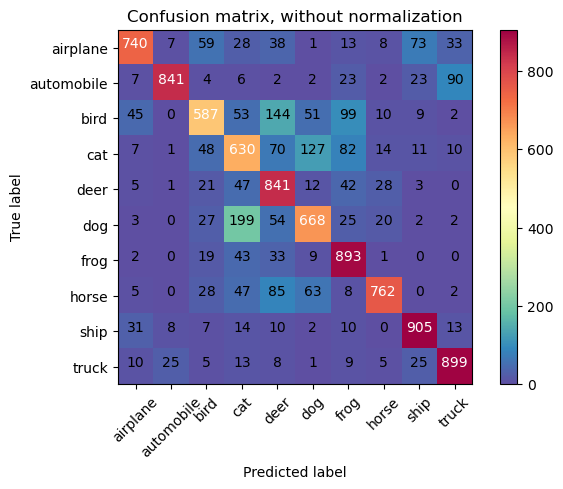

In [37]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_E_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_E_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [38]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

# compile model
opt = SGD(lr=0.001, momentum=0.9)

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_F_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train,y_train, batch_size=64,epochs=400,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_11 (Quantize  (None, 32, 32, 3)        3         
 Layer)                                                          
                                                                 
 quant_conv2d_139 (QuantizeW  (None, 32, 32, 16)       483       
 rapperV2)                                                       
                                                                 
 quant_conv2d_140 (QuantizeW  (None, 32, 32, 16)       2355      
 rapperV2)                                                       
                                                                 
 quant_max_pooling2d_82 (Qua  (None, 16, 16, 16)       1         
 ntizeWrapperV2)                                                 
                                                                 
 quant_dropout_114 (Quantize  (None, 16, 16, 16)     

Epoch 26/400
782/782 [==============================] - 11s 14ms/step - loss: 1.3485 - accuracy: 0.5128 - val_loss: 1.3752 - val_accuracy: 0.5024
Epoch 27/400
782/782 [==============================] - 11s 14ms/step - loss: 1.3329 - accuracy: 0.5179 - val_loss: 1.2412 - val_accuracy: 0.5472
Epoch 28/400
782/782 [==============================] - 11s 14ms/step - loss: 1.3149 - accuracy: 0.5260 - val_loss: 1.2149 - val_accuracy: 0.5588
Epoch 29/400
782/782 [==============================] - 11s 14ms/step - loss: 1.3094 - accuracy: 0.5288 - val_loss: 1.1887 - val_accuracy: 0.5636
Epoch 30/400
782/782 [==============================] - 11s 14ms/step - loss: 1.2929 - accuracy: 0.5348 - val_loss: 1.1713 - val_accuracy: 0.5720
Epoch 31/400
782/782 [==============================] - 11s 14ms/step - loss: 1.2756 - accuracy: 0.5423 - val_loss: 1.1392 - val_accuracy: 0.5889
Epoch 32/400
782/782 [==============================] - 11s 14ms/step - loss: 1.2654 - accuracy: 0.5436 - val_loss: 1.1165 -

782/782 [==============================] - 11s 14ms/step - loss: 0.9344 - accuracy: 0.6717 - val_loss: 0.8272 - val_accuracy: 0.7069
Epoch 83/400
782/782 [==============================] - 11s 14ms/step - loss: 0.9391 - accuracy: 0.6712 - val_loss: 0.8417 - val_accuracy: 0.6996
Epoch 84/400
782/782 [==============================] - 11s 14ms/step - loss: 0.9268 - accuracy: 0.6795 - val_loss: 0.8326 - val_accuracy: 0.7065
Epoch 85/400
782/782 [==============================] - 11s 14ms/step - loss: 0.9242 - accuracy: 0.6772 - val_loss: 0.8233 - val_accuracy: 0.7057
Epoch 86/400
782/782 [==============================] - 11s 14ms/step - loss: 0.9171 - accuracy: 0.6791 - val_loss: 0.8289 - val_accuracy: 0.7070
Epoch 87/400
782/782 [==============================] - 11s 14ms/step - loss: 0.9142 - accuracy: 0.6828 - val_loss: 0.7992 - val_accuracy: 0.7116
Epoch 88/400
782/782 [==============================] - 11s 14ms/step - loss: 0.9165 - accuracy: 0.6791 - val_loss: 0.8111 - val_accuracy

Epoch 138/400
782/782 [==============================] - 11s 13ms/step - loss: 0.7989 - accuracy: 0.7242 - val_loss: 0.7367 - val_accuracy: 0.7428
Epoch 139/400
782/782 [==============================] - 11s 14ms/step - loss: 0.7967 - accuracy: 0.7248 - val_loss: 0.7184 - val_accuracy: 0.7492
Epoch 140/400
782/782 [==============================] - 11s 13ms/step - loss: 0.7917 - accuracy: 0.7258 - val_loss: 0.7586 - val_accuracy: 0.7364
Epoch 141/400
782/782 [==============================] - 11s 14ms/step - loss: 0.7872 - accuracy: 0.7265 - val_loss: 0.6910 - val_accuracy: 0.7596
Epoch 142/400
782/782 [==============================] - 11s 14ms/step - loss: 0.7894 - accuracy: 0.7279 - val_loss: 0.7111 - val_accuracy: 0.7527
Epoch 143/400
782/782 [==============================] - 11s 14ms/step - loss: 0.7926 - accuracy: 0.7257 - val_loss: 0.7268 - val_accuracy: 0.7472
Epoch 144/400
782/782 [==============================] - 11s 14ms/step - loss: 0.7902 - accuracy: 0.7289 - val_loss: 0

In [5]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_F_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

NameError: name 'quant_aware_model' is not defined

In [40]:
c_model_name = 'cifar10_reduced_f_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_139_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_F_QAT.tflite is 79.81%
Confusion matrix, without normalization
[[871   7  26  17   7   1   9   6  39  17]
 [ 12 906   1   2   2   2  10   0  14  51]
 [ 87   1 648  32  74  53  87  13   4   1]
 [ 23   6  52 632  65 100  93  13   5  11]
 [ 13   0  40  34 804   9  67  27   6   0]
 [  6   3  44 184  41 664  30  25   1   2]
 [  7   0  27  32  19   4 903   4   3   1]
 [ 19   1  25  32  66  57   8 792   0   0]
 [ 65  15   8   8   3   0   8   2 878  13]
 [ 27  45   1  10   1   3   9   6  15 883]]


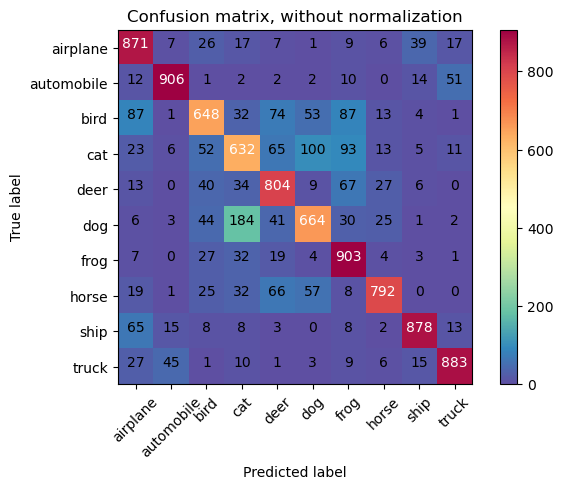

In [6]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_F_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_F_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [7]:
model_10 = Sequential()
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_G_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train,y_train, batch_size=64,epochs=400,validation_data=(x_test, y_test),
                     callbacks=[checkpoint_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 32)          0

2023-06-06 18:16:11.878972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 18:16:11.879166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 18:16:11.879291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 18:16:11.879572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 18:16:11.879705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 32, 32, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 32, 32, 32)       963       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 16, 16, 32)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_dropout (QuantizeWrap  (None, 16, 16, 32)       1         
 perV2)                                                          
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 16, 16, 32)       9

/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/400


2023-06-06 18:16:15.207237: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


  1/782 [..............................] - ETA: 30:26 - loss: 6.9937 - accuracy: 0.1094

2023-06-06 18:16:16.240163: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


782/782 [==============================] - 10s 10ms/step - loss: 2.3457 - accuracy: 0.1266 - val_loss: 2.2512 - val_accuracy: 0.1618
Epoch 2/400
782/782 [==============================] - 7s 9ms/step - loss: 2.1894 - accuracy: 0.1792 - val_loss: 2.1610 - val_accuracy: 0.2091
Epoch 3/400
782/782 [==============================] - 7s 9ms/step - loss: 2.1007 - accuracy: 0.2072 - val_loss: 2.1801 - val_accuracy: 0.1884
Epoch 4/400
782/782 [==============================] - 7s 9ms/step - loss: 2.0016 - accuracy: 0.2328 - val_loss: 2.0446 - val_accuracy: 0.2360
Epoch 5/400
782/782 [==============================] - 7s 9ms/step - loss: 1.9354 - accuracy: 0.2531 - val_loss: 2.0081 - val_accuracy: 0.2518
Epoch 6/400
782/782 [==============================] - 7s 9ms/step - loss: 1.8807 - accuracy: 0.2724 - val_loss: 2.0563 - val_accuracy: 0.2472
Epoch 7/400
782/782 [==============================] - 7s 9ms/step - loss: 1.8488 - accuracy: 0.2867 - val_loss: 1.8472 - val_accuracy: 0.3196
Epoch 8/4

Epoch 58/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1461 - accuracy: 0.5914 - val_loss: 1.1126 - val_accuracy: 0.6103
Epoch 59/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1436 - accuracy: 0.5909 - val_loss: 1.0834 - val_accuracy: 0.6232
Epoch 60/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1397 - accuracy: 0.5927 - val_loss: 1.0933 - val_accuracy: 0.6171
Epoch 61/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1378 - accuracy: 0.5941 - val_loss: 1.0704 - val_accuracy: 0.6240
Epoch 62/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1292 - accuracy: 0.5953 - val_loss: 1.0134 - val_accuracy: 0.6468
Epoch 63/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1202 - accuracy: 0.6003 - val_loss: 1.1967 - val_accuracy: 0.5950
Epoch 64/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1164 - accuracy: 0.6020 - val_loss: 1.0178 - val_accuracy:

Epoch 115/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9319 - accuracy: 0.6731 - val_loss: 0.8279 - val_accuracy: 0.7153
Epoch 116/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9248 - accuracy: 0.6749 - val_loss: 0.8065 - val_accuracy: 0.7183
Epoch 117/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9210 - accuracy: 0.6781 - val_loss: 0.8439 - val_accuracy: 0.7067
Epoch 118/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9230 - accuracy: 0.6785 - val_loss: 0.8526 - val_accuracy: 0.7037
Epoch 119/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9200 - accuracy: 0.6792 - val_loss: 0.8895 - val_accuracy: 0.6901
Epoch 120/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9226 - accuracy: 0.6793 - val_loss: 0.8649 - val_accuracy: 0.6999
Epoch 121/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9149 - accuracy: 0.6807 - val_loss: 0.8026 - val_ac

782/782 [==============================] - 7s 9ms/step - loss: 0.8228 - accuracy: 0.7156 - val_loss: 0.7645 - val_accuracy: 0.7352
Epoch 172/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8240 - accuracy: 0.7146 - val_loss: 0.7791 - val_accuracy: 0.7323
Epoch 173/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8193 - accuracy: 0.7171 - val_loss: 0.7269 - val_accuracy: 0.7468
Epoch 174/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8151 - accuracy: 0.7176 - val_loss: 0.7133 - val_accuracy: 0.7544
Epoch 175/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8194 - accuracy: 0.7178 - val_loss: 0.7326 - val_accuracy: 0.7465
Epoch 176/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8188 - accuracy: 0.7172 - val_loss: 0.7357 - val_accuracy: 0.7448
Epoch 177/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8173 - accuracy: 0.7165 - val_loss: 0.7276 - val_accuracy: 0.7444

782/782 [==============================] - 7s 9ms/step - loss: 0.7612 - accuracy: 0.7406 - val_loss: 0.7118 - val_accuracy: 0.7542
Epoch 228/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7638 - accuracy: 0.7350 - val_loss: 0.6754 - val_accuracy: 0.7683
Epoch 229/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7602 - accuracy: 0.7369 - val_loss: 0.7029 - val_accuracy: 0.7602
Epoch 230/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7646 - accuracy: 0.7379 - val_loss: 0.6749 - val_accuracy: 0.7700
Epoch 231/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7538 - accuracy: 0.7405 - val_loss: 0.6656 - val_accuracy: 0.7708
Epoch 232/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7557 - accuracy: 0.7381 - val_loss: 0.7044 - val_accuracy: 0.7594
Epoch 233/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7615 - accuracy: 0.7371 - val_loss: 0.7117 - val_accuracy: 0.7565

782/782 [==============================] - 7s 9ms/step - loss: 0.7211 - accuracy: 0.7524 - val_loss: 0.6524 - val_accuracy: 0.7743
Epoch 284/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7210 - accuracy: 0.7531 - val_loss: 0.6481 - val_accuracy: 0.7769
Epoch 285/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7200 - accuracy: 0.7515 - val_loss: 0.6525 - val_accuracy: 0.7784
Epoch 286/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7271 - accuracy: 0.7502 - val_loss: 0.6432 - val_accuracy: 0.7798
Epoch 287/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7159 - accuracy: 0.7567 - val_loss: 0.6309 - val_accuracy: 0.7819
Epoch 288/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7168 - accuracy: 0.7553 - val_loss: 0.6557 - val_accuracy: 0.7724
Epoch 289/400
782/782 [==============================] - 7s 9ms/step - loss: 0.7188 - accuracy: 0.7540 - val_loss: 0.6992 - val_accuracy: 0.7646

782/782 [==============================] - 7s 10ms/step - loss: 0.6908 - accuracy: 0.7644 - val_loss: 0.6516 - val_accuracy: 0.7749
Epoch 340/400
782/782 [==============================] - 7s 10ms/step - loss: 0.6974 - accuracy: 0.7615 - val_loss: 0.6352 - val_accuracy: 0.7825
Epoch 341/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6941 - accuracy: 0.7622 - val_loss: 0.6100 - val_accuracy: 0.7906
Epoch 342/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6880 - accuracy: 0.7637 - val_loss: 0.6339 - val_accuracy: 0.7841
Epoch 343/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6920 - accuracy: 0.7613 - val_loss: 0.6440 - val_accuracy: 0.7802
Epoch 344/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6911 - accuracy: 0.7613 - val_loss: 0.6309 - val_accuracy: 0.7844
Epoch 345/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6971 - accuracy: 0.7617 - val_loss: 0.6287 - val_accuracy: 0.78

782/782 [==============================] - 7s 9ms/step - loss: 0.6664 - accuracy: 0.7732 - val_loss: 0.5907 - val_accuracy: 0.8007
Epoch 396/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6704 - accuracy: 0.7701 - val_loss: 0.6022 - val_accuracy: 0.7937
Epoch 397/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6753 - accuracy: 0.7693 - val_loss: 0.6181 - val_accuracy: 0.7877
Epoch 398/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6713 - accuracy: 0.7707 - val_loss: 0.6447 - val_accuracy: 0.7780
Epoch 399/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6720 - accuracy: 0.7714 - val_loss: 0.6147 - val_accuracy: 0.7894
Epoch 400/400
782/782 [==============================] - 7s 9ms/step - loss: 0.6672 - accuracy: 0.7709 - val_loss: 0.5817 - val_accuracy: 0.7998


In [8]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_G_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.5817064046859741
Quantization aware training accuracy:  0.7997999787330627


INFO:tensorflow:Assets written to: /tmp/tmpem4__3bm/assets


INFO:tensorflow:Assets written to: /tmp/tmpem4__3bm/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 19:05:02.023207: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 19:05:02.023239: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 19:05:02.023811: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpem4__3bm
2023-06-06 19:05:02.028535: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 19:05:02.028552: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpem4__3bm
2023-06-06 19:05:02.045881: I tensorflow/

112168

In [9]:
c_model_name = 'cifar10_reduced_g_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_G_QAT.tflite is 79.9%
Confusion matrix, without normalization
[[795  11  29  18  24   2  11   7  73  30]
 [  7 916   0   4   1   3   6   0  18  45]
 [ 54   2 679  42  79  42  74  14   9   5]
 [ 11   5  50 604  64 134  82  21  10  19]
 [ 10   2  31  41 804  15  61  29   5   2]
 [ 10   2  37 158  44 693  16  31   5   4]
 [  4   2  23  36  17   8 904   3   2   1]
 [ 12   4  33  43  59  36   4 802   1   6]
 [ 30  15   7   8   5   0   4   2 917  12]
 [ 14  57   6   8   2   1   4   3  29 876]]


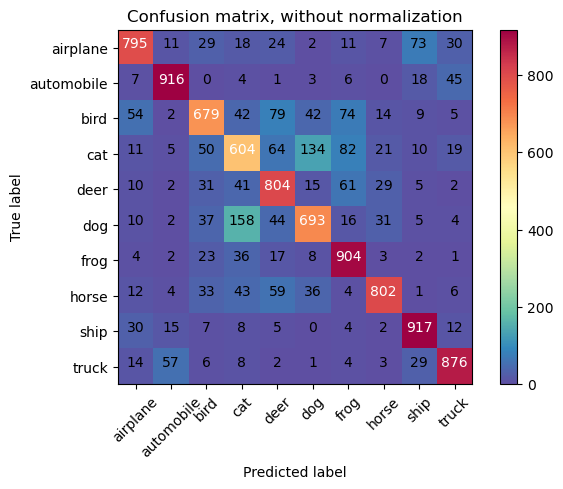

In [10]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_G_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_G_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [11]:
model_10 = Sequential()
model_10.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.1))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.4))
model_10.add(Dense(10, activation='softmax'))

model_10.summary()

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# define the ModelCheckpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_H_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train,y_train, batch_size=64,epochs=400,validation_data=(x_test, y_test),
                     callbacks=[checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 16)         

/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/400
782/782 [==============================] - 6s 7ms/step - loss: 2.2872 - accuracy: 0.1380 - val_loss: 2.2273 - val_accuracy: 0.2286
Epoch 2/400
782/782 [==============================] - 5s 6ms/step - loss: 2.1662 - accuracy: 0.2070 - val_loss: 2.0131 - val_accuracy: 0.3110
Epoch 3/400
782/782 [==============================] - 5s 6ms/step - loss: 1.9555 - accuracy: 0.2733 - val_loss: 1.8027 - val_accuracy: 0.3445
Epoch 4/400
782/782 [==============================] - 5s 6ms/step - loss: 1.8325 - accuracy: 0.3127 - val_loss: 1.7006 - val_accuracy: 0.3808
Epoch 5/400
782/782 [==============================] - 5s 6ms/step - loss: 1.7600 - accuracy: 0.3428 - val_loss: 1.6463 - val_accuracy: 0.4103
Epoch 6/400
782/782 [==============================] - 5s 6ms/step - loss: 1.7060 - accuracy: 0.3630 - val_loss: 1.5989 - val_accuracy: 0.4260
Epoch 7/400
782/782 [==============================] - 5s 6ms/step - loss: 1.6688 - accuracy: 0.3769 - val_loss: 1.5492 - val_accuracy: 0.4413

Epoch 58/400
782/782 [==============================] - 5s 6ms/step - loss: 1.2147 - accuracy: 0.5630 - val_loss: 1.0754 - val_accuracy: 0.6192
Epoch 59/400
782/782 [==============================] - 5s 6ms/step - loss: 1.2108 - accuracy: 0.5666 - val_loss: 1.0963 - val_accuracy: 0.6109
Epoch 60/400
782/782 [==============================] - 5s 6ms/step - loss: 1.2097 - accuracy: 0.5649 - val_loss: 1.0767 - val_accuracy: 0.6198
Epoch 61/400
782/782 [==============================] - 5s 6ms/step - loss: 1.2058 - accuracy: 0.5674 - val_loss: 1.1093 - val_accuracy: 0.6060
Epoch 62/400
782/782 [==============================] - 5s 6ms/step - loss: 1.1999 - accuracy: 0.5699 - val_loss: 1.0744 - val_accuracy: 0.6193
Epoch 63/400
782/782 [==============================] - 5s 6ms/step - loss: 1.2010 - accuracy: 0.5717 - val_loss: 1.1030 - val_accuracy: 0.6069
Epoch 64/400
782/782 [==============================] - 5s 6ms/step - loss: 1.1942 - accuracy: 0.5691 - val_loss: 1.0694 - val_accuracy:

Epoch 115/400
782/782 [==============================] - 5s 7ms/step - loss: 1.0708 - accuracy: 0.6182 - val_loss: 0.9440 - val_accuracy: 0.6657
Epoch 116/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0711 - accuracy: 0.6166 - val_loss: 0.9447 - val_accuracy: 0.6707
Epoch 117/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0738 - accuracy: 0.6175 - val_loss: 0.9312 - val_accuracy: 0.6743
Epoch 118/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0720 - accuracy: 0.6198 - val_loss: 0.9344 - val_accuracy: 0.6748
Epoch 119/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0733 - accuracy: 0.6177 - val_loss: 0.9363 - val_accuracy: 0.6733
Epoch 120/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0676 - accuracy: 0.6210 - val_loss: 0.9311 - val_accuracy: 0.6755
Epoch 121/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0668 - accuracy: 0.6207 - val_loss: 0.9311 - val_ac

782/782 [==============================] - 5s 6ms/step - loss: 1.0066 - accuracy: 0.6429 - val_loss: 0.8714 - val_accuracy: 0.6934
Epoch 172/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0050 - accuracy: 0.6430 - val_loss: 0.8899 - val_accuracy: 0.6908
Epoch 173/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0019 - accuracy: 0.6475 - val_loss: 0.8751 - val_accuracy: 0.6951
Epoch 174/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0025 - accuracy: 0.6443 - val_loss: 0.8656 - val_accuracy: 0.6950
Epoch 175/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0029 - accuracy: 0.6451 - val_loss: 0.8735 - val_accuracy: 0.6902
Epoch 176/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0006 - accuracy: 0.6461 - val_loss: 0.9041 - val_accuracy: 0.6832
Epoch 177/400
782/782 [==============================] - 5s 6ms/step - loss: 1.0007 - accuracy: 0.6444 - val_loss: 0.8905 - val_accuracy: 0.6910

782/782 [==============================] - 5s 6ms/step - loss: 0.9650 - accuracy: 0.6583 - val_loss: 0.8585 - val_accuracy: 0.6984
Epoch 228/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9644 - accuracy: 0.6584 - val_loss: 0.8581 - val_accuracy: 0.6989
Epoch 229/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9570 - accuracy: 0.6604 - val_loss: 0.8373 - val_accuracy: 0.7063
Epoch 230/400
782/782 [==============================] - 5s 7ms/step - loss: 0.9632 - accuracy: 0.6587 - val_loss: 0.8430 - val_accuracy: 0.7027
Epoch 231/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9676 - accuracy: 0.6572 - val_loss: 0.8470 - val_accuracy: 0.7048
Epoch 232/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9663 - accuracy: 0.6582 - val_loss: 0.8457 - val_accuracy: 0.7026
Epoch 233/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9631 - accuracy: 0.6601 - val_loss: 0.8386 - val_accuracy: 0.7059

782/782 [==============================] - 5s 7ms/step - loss: 0.9359 - accuracy: 0.6702 - val_loss: 0.8625 - val_accuracy: 0.6981
Epoch 284/400
782/782 [==============================] - 5s 7ms/step - loss: 0.9391 - accuracy: 0.6684 - val_loss: 0.8299 - val_accuracy: 0.7122
Epoch 285/400
782/782 [==============================] - 5s 7ms/step - loss: 0.9361 - accuracy: 0.6657 - val_loss: 0.8260 - val_accuracy: 0.7134
Epoch 286/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9366 - accuracy: 0.6679 - val_loss: 0.8344 - val_accuracy: 0.7114
Epoch 287/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9389 - accuracy: 0.6694 - val_loss: 0.8070 - val_accuracy: 0.7187
Epoch 288/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9314 - accuracy: 0.6693 - val_loss: 0.8105 - val_accuracy: 0.7178
Epoch 289/400
782/782 [==============================] - 5s 7ms/step - loss: 0.9355 - accuracy: 0.6697 - val_loss: 0.8300 - val_accuracy: 0.7094

782/782 [==============================] - 5s 6ms/step - loss: 0.9144 - accuracy: 0.6767 - val_loss: 0.7969 - val_accuracy: 0.7228
Epoch 340/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9148 - accuracy: 0.6777 - val_loss: 0.8130 - val_accuracy: 0.7159
Epoch 341/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9080 - accuracy: 0.6775 - val_loss: 0.8062 - val_accuracy: 0.7138
Epoch 342/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9165 - accuracy: 0.6772 - val_loss: 0.8251 - val_accuracy: 0.7093
Epoch 343/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9147 - accuracy: 0.6766 - val_loss: 0.8076 - val_accuracy: 0.7191
Epoch 344/400
782/782 [==============================] - 5s 7ms/step - loss: 0.9149 - accuracy: 0.6773 - val_loss: 0.8186 - val_accuracy: 0.7142
Epoch 345/400
782/782 [==============================] - 5s 6ms/step - loss: 0.9109 - accuracy: 0.6789 - val_loss: 0.8055 - val_accuracy: 0.7205

782/782 [==============================] - 5s 7ms/step - loss: 0.8992 - accuracy: 0.6826 - val_loss: 0.8097 - val_accuracy: 0.7111
Epoch 396/400
782/782 [==============================] - 5s 7ms/step - loss: 0.9006 - accuracy: 0.6826 - val_loss: 0.8007 - val_accuracy: 0.7213
Epoch 397/400
782/782 [==============================] - 5s 7ms/step - loss: 0.8933 - accuracy: 0.6853 - val_loss: 0.7808 - val_accuracy: 0.7270
Epoch 398/400
782/782 [==============================] - 5s 7ms/step - loss: 0.9014 - accuracy: 0.6814 - val_loss: 0.8123 - val_accuracy: 0.7166
Epoch 399/400
782/782 [==============================] - 5s 7ms/step - loss: 0.9016 - accuracy: 0.6817 - val_loss: 0.8102 - val_accuracy: 0.7178
Epoch 400/400
782/782 [==============================] - 5s 7ms/step - loss: 0.8948 - accuracy: 0.6811 - val_loss: 0.7909 - val_accuracy: 0.7225


In [12]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_H_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.7909085154533386
Quantization aware training accuracy:  0.7225000262260437


INFO:tensorflow:Assets written to: /tmp/tmppk3fxbor/assets


INFO:tensorflow:Assets written to: /tmp/tmppk3fxbor/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 19:43:45.910673: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 19:43:45.910705: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 19:43:45.910853: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppk3fxbor
2023-06-06 19:43:45.915440: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 19:43:45.915457: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppk3fxbor
2023-06-06 19:43:45.927846: I tensorflow/

80872

In [13]:
c_model_name = 'cifar10_reduced_h_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_4_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_H_QAT.tflite is 72.38%
Confusion matrix, without normalization
[[726  17  60  21  24   5  17  14  84  32]
 [ 13 826   2  10   4   4  14   2  31  94]
 [ 67   3 545  52 140  45 104  26  15   3]
 [ 12   6  56 528  86 136 128  24  15   9]
 [ 18   1  43  53 731  13  99  35   6   1]
 [  4   3  49 212  69 555  63  33   8   4]
 [  1   2  24  31  42  13 881   1   4   1]
 [  7   3  38  54 105  56  14 712   2   9]
 [ 34  18  10  17   7   2   9   3 879  21]
 [ 23  45   3  15   9   2  14  12  22 855]]


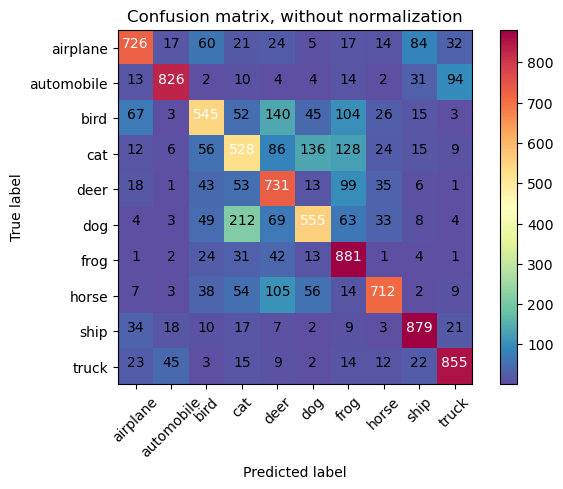

In [14]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_H_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_H_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [15]:
model_10 = Sequential()
model_10.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((2, 2)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_I_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train,y_train, batch_size=64,epochs=400,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_2 (QuantizeL  (None, 32, 32, 3)        3         
 ayer)                                                           
                                                                 
 quant_conv2d_7 (QuantizeWra  (None, 32, 32, 8)        243       
 pperV2)                                                         
                                                                 
 quant_conv2d_8 (QuantizeWra  (None, 32, 32, 8)        603       
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_7 (Quan  (None, 16, 16, 8)        1         
 tizeWrapperV2)                                                  
                                                                 
 quant_dropout_9 (QuantizeWr  (None, 16, 16, 8)       

782/782 [==============================] - 7s 9ms/step - loss: 1.4281 - accuracy: 0.4786 - val_loss: 1.2944 - val_accuracy: 0.5285
Epoch 32/400
782/782 [==============================] - 7s 9ms/step - loss: 1.4213 - accuracy: 0.4768 - val_loss: 1.3045 - val_accuracy: 0.5227
Epoch 33/400
782/782 [==============================] - 7s 9ms/step - loss: 1.4145 - accuracy: 0.4819 - val_loss: 1.3010 - val_accuracy: 0.5282
Epoch 34/400
782/782 [==============================] - 7s 9ms/step - loss: 1.4057 - accuracy: 0.4857 - val_loss: 1.3114 - val_accuracy: 0.5236
Epoch 35/400
782/782 [==============================] - 7s 9ms/step - loss: 1.3945 - accuracy: 0.4951 - val_loss: 1.2659 - val_accuracy: 0.5409
Epoch 36/400
782/782 [==============================] - 7s 9ms/step - loss: 1.3880 - accuracy: 0.4936 - val_loss: 1.2460 - val_accuracy: 0.5497
Epoch 37/400
782/782 [==============================] - 7s 9ms/step - loss: 1.3785 - accuracy: 0.4961 - val_loss: 1.2148 - val_accuracy: 0.5570
Epoch

Epoch 88/400
782/782 [==============================] - 7s 10ms/step - loss: 1.1510 - accuracy: 0.5908 - val_loss: 0.9863 - val_accuracy: 0.6431
Epoch 89/400
782/782 [==============================] - 8s 10ms/step - loss: 1.1534 - accuracy: 0.5888 - val_loss: 0.9802 - val_accuracy: 0.6487
Epoch 90/400
782/782 [==============================] - 8s 10ms/step - loss: 1.1477 - accuracy: 0.5933 - val_loss: 1.0369 - val_accuracy: 0.6196
Epoch 91/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1443 - accuracy: 0.5944 - val_loss: 1.0394 - val_accuracy: 0.6295
Epoch 92/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1438 - accuracy: 0.5978 - val_loss: 1.0249 - val_accuracy: 0.6345
Epoch 93/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1322 - accuracy: 0.5963 - val_loss: 0.9717 - val_accuracy: 0.6492
Epoch 94/400
782/782 [==============================] - 7s 9ms/step - loss: 1.1412 - accuracy: 0.5959 - val_loss: 0.9865 - val_accura

782/782 [==============================] - 7s 9ms/step - loss: 1.0377 - accuracy: 0.6345 - val_loss: 0.9069 - val_accuracy: 0.6746
Epoch 145/400
782/782 [==============================] - 7s 9ms/step - loss: 1.0415 - accuracy: 0.6366 - val_loss: 0.9286 - val_accuracy: 0.6670
Epoch 146/400
782/782 [==============================] - 7s 9ms/step - loss: 1.0337 - accuracy: 0.6360 - val_loss: 0.8982 - val_accuracy: 0.6783
Epoch 147/400
782/782 [==============================] - 7s 9ms/step - loss: 1.0374 - accuracy: 0.6348 - val_loss: 0.8862 - val_accuracy: 0.6787
Epoch 148/400
782/782 [==============================] - 7s 9ms/step - loss: 1.0368 - accuracy: 0.6370 - val_loss: 0.8820 - val_accuracy: 0.6856
Epoch 149/400
782/782 [==============================] - 7s 9ms/step - loss: 1.0378 - accuracy: 0.6330 - val_loss: 0.9167 - val_accuracy: 0.6657
Epoch 150/400
782/782 [==============================] - 7s 9ms/step - loss: 1.0345 - accuracy: 0.6344 - val_loss: 0.8890 - val_accuracy: 0.6834

782/782 [==============================] - 7s 9ms/step - loss: 0.9838 - accuracy: 0.6551 - val_loss: 0.8594 - val_accuracy: 0.6975
Epoch 201/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9788 - accuracy: 0.6574 - val_loss: 0.8938 - val_accuracy: 0.6862
Epoch 202/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9747 - accuracy: 0.6584 - val_loss: 0.8532 - val_accuracy: 0.6951
Epoch 203/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9749 - accuracy: 0.6579 - val_loss: 0.8319 - val_accuracy: 0.7034
Epoch 204/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9760 - accuracy: 0.6598 - val_loss: 0.8371 - val_accuracy: 0.7006
Epoch 205/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9716 - accuracy: 0.6607 - val_loss: 0.8582 - val_accuracy: 0.6914
Epoch 206/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9687 - accuracy: 0.6622 - val_loss: 0.8381 - val_accuracy: 0.7015

782/782 [==============================] - 7s 9ms/step - loss: 0.9305 - accuracy: 0.6743 - val_loss: 0.8143 - val_accuracy: 0.7103
Epoch 257/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9358 - accuracy: 0.6748 - val_loss: 0.7966 - val_accuracy: 0.7123
Epoch 258/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9362 - accuracy: 0.6739 - val_loss: 0.8386 - val_accuracy: 0.7010
Epoch 259/400
782/782 [==============================] - 7s 10ms/step - loss: 0.9306 - accuracy: 0.6782 - val_loss: 0.8025 - val_accuracy: 0.7198
Epoch 260/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9304 - accuracy: 0.6762 - val_loss: 0.8294 - val_accuracy: 0.7046
Epoch 261/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9272 - accuracy: 0.6789 - val_loss: 0.8271 - val_accuracy: 0.7035
Epoch 262/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9345 - accuracy: 0.6758 - val_loss: 0.7789 - val_accuracy: 0.725

782/782 [==============================] - 7s 10ms/step - loss: 0.8993 - accuracy: 0.6857 - val_loss: 0.7760 - val_accuracy: 0.7268
Epoch 313/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9031 - accuracy: 0.6883 - val_loss: 0.7546 - val_accuracy: 0.7362
Epoch 314/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9074 - accuracy: 0.6860 - val_loss: 0.7661 - val_accuracy: 0.7289
Epoch 315/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8994 - accuracy: 0.6874 - val_loss: 0.7744 - val_accuracy: 0.7301
Epoch 316/400
782/782 [==============================] - 7s 9ms/step - loss: 0.9057 - accuracy: 0.6856 - val_loss: 0.7896 - val_accuracy: 0.7173
Epoch 317/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8964 - accuracy: 0.6887 - val_loss: 0.7722 - val_accuracy: 0.7245
Epoch 318/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8961 - accuracy: 0.6875 - val_loss: 0.7738 - val_accuracy: 0.729

782/782 [==============================] - 7s 9ms/step - loss: 0.8835 - accuracy: 0.6939 - val_loss: 0.7397 - val_accuracy: 0.7395
Epoch 369/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8805 - accuracy: 0.6972 - val_loss: 0.7621 - val_accuracy: 0.7324
Epoch 370/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8854 - accuracy: 0.6925 - val_loss: 0.7442 - val_accuracy: 0.7387
Epoch 371/400
782/782 [==============================] - 7s 10ms/step - loss: 0.8826 - accuracy: 0.6952 - val_loss: 0.7589 - val_accuracy: 0.7316
Epoch 372/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8812 - accuracy: 0.6929 - val_loss: 0.7497 - val_accuracy: 0.7368
Epoch 373/400
782/782 [==============================] - 7s 9ms/step - loss: 0.8781 - accuracy: 0.6970 - val_loss: 0.7570 - val_accuracy: 0.7343
Epoch 374/400
782/782 [==============================] - 8s 10ms/step - loss: 0.8780 - accuracy: 0.6970 - val_loss: 0.7616 - val_accuracy: 0.73

In [19]:
quant_aware_model.save('model_10_Reduced_I_QAT.h5')

# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_I_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.7526677250862122
Quantization aware training accuracy:  0.739300012588501


INFO:tensorflow:Assets written to: /tmp/tmps2025mja/assets


INFO:tensorflow:Assets written to: /tmp/tmps2025mja/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 20:37:00.238132: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 20:37:00.238162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 20:37:00.238327: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps2025mja
2023-06-06 20:37:00.250723: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 20:37:00.250758: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps2025mja
2023-06-06 20:37:00.294049: I tensorflow/

63072

In [20]:
c_model_name = 'cifar10_reduced_i_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_7_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_I_QAT.tflite is 73.89%
Confusion matrix, without normalization
[[740  12  42  37  12   6   6  12  92  41]
 [  9 875   2   7   0   5   8   0  21  73]
 [ 73   2 495  84  98 121  83  25  11   8]
 [ 13   4  33 598  38 199  66  25  10  14]
 [ 19   1  30 118 658  31  80  53   7   3]
 [  5   1  13 213  26 689  10  36   2   5]
 [  5   0  22  79  19  27 842   1   4   1]
 [  8   2  13  50  41 127   5 733   4  17]
 [ 48  25   3  15   5   5   4   3 874  18]
 [ 17  47   1  13   1   4   1   5  26 885]]


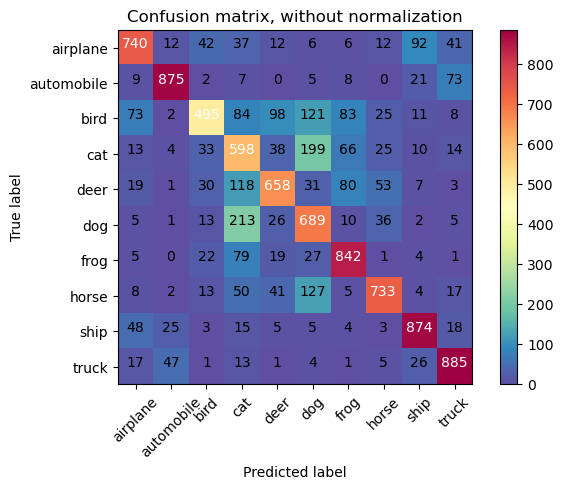

In [21]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_I_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_I_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [27]:
model_10 = Sequential()
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((4, 4)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((4, 4)))
model_10.add(Dropout(0.3))
model_10.add(Flatten())
model_10.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_J_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train,y_train, batch_size=64,epochs=400,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_8 (QuantizeL  (None, 32, 32, 3)        3         
 ayer)                                                           
                                                                 
 quant_conv2d_38 (QuantizeWr  (None, 32, 32, 16)       483       
 apperV2)                                                        
                                                                 
 quant_conv2d_39 (QuantizeWr  (None, 32, 32, 16)       2355      
 apperV2)                                                        
                                                                 
 quant_max_pooling2d_21 (Qua  (None, 8, 8, 16)         1         
 ntizeWrapperV2)                                                 
                                                                 
 quant_dropout_29 (QuantizeW  (None, 8, 8, 16)        

782/782 [==============================] - 6s 8ms/step - loss: 1.3445 - accuracy: 0.5149 - val_loss: 1.1518 - val_accuracy: 0.5948
Epoch 38/400
782/782 [==============================] - 6s 8ms/step - loss: 1.3358 - accuracy: 0.5171 - val_loss: 1.1658 - val_accuracy: 0.5827
Epoch 39/400
782/782 [==============================] - 6s 8ms/step - loss: 1.3307 - accuracy: 0.5214 - val_loss: 1.1670 - val_accuracy: 0.5930
Epoch 40/400
782/782 [==============================] - 6s 8ms/step - loss: 1.3269 - accuracy: 0.5245 - val_loss: 1.1586 - val_accuracy: 0.5847
Epoch 41/400
782/782 [==============================] - 6s 8ms/step - loss: 1.3216 - accuracy: 0.5261 - val_loss: 1.1373 - val_accuracy: 0.5961
Epoch 42/400
782/782 [==============================] - 6s 8ms/step - loss: 1.3083 - accuracy: 0.5307 - val_loss: 1.1163 - val_accuracy: 0.6001
Epoch 43/400
782/782 [==============================] - 6s 8ms/step - loss: 1.3063 - accuracy: 0.5333 - val_loss: 1.1401 - val_accuracy: 0.5935
Epoch

Epoch 94/400
782/782 [==============================] - 6s 8ms/step - loss: 1.0997 - accuracy: 0.6145 - val_loss: 0.9195 - val_accuracy: 0.6760
Epoch 95/400
782/782 [==============================] - 6s 8ms/step - loss: 1.1003 - accuracy: 0.6125 - val_loss: 0.9383 - val_accuracy: 0.6663
Epoch 96/400
782/782 [==============================] - 6s 8ms/step - loss: 1.0913 - accuracy: 0.6143 - val_loss: 0.9238 - val_accuracy: 0.6721
Epoch 97/400
782/782 [==============================] - 6s 8ms/step - loss: 1.0906 - accuracy: 0.6174 - val_loss: 0.9304 - val_accuracy: 0.6674
Epoch 98/400
782/782 [==============================] - 6s 8ms/step - loss: 1.0841 - accuracy: 0.6198 - val_loss: 0.9495 - val_accuracy: 0.6616
Epoch 99/400
782/782 [==============================] - 6s 8ms/step - loss: 1.0809 - accuracy: 0.6204 - val_loss: 0.9142 - val_accuracy: 0.6710
Epoch 100/400
782/782 [==============================] - 6s 8ms/step - loss: 1.0798 - accuracy: 0.6223 - val_loss: 0.9030 - val_accuracy

782/782 [==============================] - 6s 8ms/step - loss: 0.9952 - accuracy: 0.6540 - val_loss: 0.8328 - val_accuracy: 0.7038
Epoch 151/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9949 - accuracy: 0.6533 - val_loss: 0.8356 - val_accuracy: 0.7061
Epoch 152/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9867 - accuracy: 0.6564 - val_loss: 0.8415 - val_accuracy: 0.7014
Epoch 153/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9857 - accuracy: 0.6568 - val_loss: 0.8407 - val_accuracy: 0.7009
Epoch 154/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9873 - accuracy: 0.6559 - val_loss: 0.8464 - val_accuracy: 0.6966
Epoch 155/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9849 - accuracy: 0.6558 - val_loss: 0.8339 - val_accuracy: 0.7033
Epoch 156/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9932 - accuracy: 0.6543 - val_loss: 0.8224 - val_accuracy: 0.7072

782/782 [==============================] - 6s 7ms/step - loss: 0.9355 - accuracy: 0.6742 - val_loss: 0.7831 - val_accuracy: 0.7224
Epoch 207/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9364 - accuracy: 0.6732 - val_loss: 0.7980 - val_accuracy: 0.7174
Epoch 208/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9355 - accuracy: 0.6746 - val_loss: 0.8049 - val_accuracy: 0.7151
Epoch 209/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9333 - accuracy: 0.6763 - val_loss: 0.7913 - val_accuracy: 0.7185
Epoch 210/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9370 - accuracy: 0.6752 - val_loss: 0.7937 - val_accuracy: 0.7184
Epoch 211/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9268 - accuracy: 0.6791 - val_loss: 0.7944 - val_accuracy: 0.7163
Epoch 212/400
782/782 [==============================] - 6s 8ms/step - loss: 0.9337 - accuracy: 0.6764 - val_loss: 0.7935 - val_accuracy: 0.7200

782/782 [==============================] - 6s 7ms/step - loss: 0.8957 - accuracy: 0.6887 - val_loss: 0.7823 - val_accuracy: 0.7241
Epoch 263/400
782/782 [==============================] - 6s 7ms/step - loss: 0.8997 - accuracy: 0.6894 - val_loss: 0.7644 - val_accuracy: 0.7321
Epoch 264/400
782/782 [==============================] - 6s 7ms/step - loss: 0.8964 - accuracy: 0.6905 - val_loss: 0.7675 - val_accuracy: 0.7316
Epoch 265/400
782/782 [==============================] - 6s 7ms/step - loss: 0.8998 - accuracy: 0.6862 - val_loss: 0.7630 - val_accuracy: 0.7313
Epoch 266/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8957 - accuracy: 0.6895 - val_loss: 0.7608 - val_accuracy: 0.7343
Epoch 267/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8904 - accuracy: 0.6914 - val_loss: 0.7649 - val_accuracy: 0.7292
Epoch 268/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8980 - accuracy: 0.6876 - val_loss: 0.7856 - val_accuracy: 0.7238

782/782 [==============================] - 6s 8ms/step - loss: 0.8761 - accuracy: 0.6988 - val_loss: 0.7602 - val_accuracy: 0.7343
Epoch 319/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8766 - accuracy: 0.6971 - val_loss: 0.7526 - val_accuracy: 0.7364
Epoch 320/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8659 - accuracy: 0.7010 - val_loss: 0.7536 - val_accuracy: 0.7348
Epoch 321/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8719 - accuracy: 0.6970 - val_loss: 0.7457 - val_accuracy: 0.7381
Epoch 322/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8685 - accuracy: 0.6983 - val_loss: 0.7416 - val_accuracy: 0.7400
Epoch 323/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8690 - accuracy: 0.6978 - val_loss: 0.7530 - val_accuracy: 0.7375
Epoch 324/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8694 - accuracy: 0.6989 - val_loss: 0.7656 - val_accuracy: 0.7337

782/782 [==============================] - 6s 8ms/step - loss: 0.8491 - accuracy: 0.7035 - val_loss: 0.7376 - val_accuracy: 0.7463
Epoch 375/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8478 - accuracy: 0.7049 - val_loss: 0.7366 - val_accuracy: 0.7401
Epoch 376/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8567 - accuracy: 0.7038 - val_loss: 0.7311 - val_accuracy: 0.7483
Epoch 377/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8492 - accuracy: 0.7085 - val_loss: 0.7357 - val_accuracy: 0.7453
Epoch 378/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8558 - accuracy: 0.7034 - val_loss: 0.7641 - val_accuracy: 0.7364
Epoch 379/400
782/782 [==============================] - 6s 8ms/step - loss: 0.8523 - accuracy: 0.7065 - val_loss: 0.7449 - val_accuracy: 0.7417
Epoch 380/400
782/782 [==============================] - 6s 7ms/step - loss: 0.8537 - accuracy: 0.7062 - val_loss: 0.7274 - val_accuracy: 0.7490

In [28]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_J_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

Quantization aware training loss:  0.7291662096977234
Quantization aware training accuracy:  0.7494999766349792


INFO:tensorflow:Assets written to: /tmp/tmpetrvgzyo/assets


INFO:tensorflow:Assets written to: /tmp/tmpetrvgzyo/assets
/home/themandalorian/anaconda3/envs/ml-on-mc/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-06 21:29:12.685266: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 21:29:12.685298: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-06 21:29:12.685449: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpetrvgzyo
2023-06-06 21:29:12.693186: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 21:29:12.693208: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpetrvgzyo
2023-06-06 21:29:12.712722: I tensorflow/

34928

In [29]:
c_model_name = 'cifar10_reduced_j_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

== Input details ==
name: serving_default_conv2d_38_input:0
shape: [ 1 32 32  3]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.uint8'>
Accuracy of model_10_Reduced_J_QAT.tflite is 74.67%
Confusion matrix, without normalization
[[773  21  58  24   7   1   5   7  78  26]
 [  6 883   3   6   1   1   8   1  24  67]
 [ 61   7 583  54  98  61  97  19  15   5]
 [ 23   9  63 600  59 121  78  16  21  10]
 [ 23   4  63  71 695  19  65  51   8   1]
 [ 10   5  48 231  49 594  15  39   7   2]
 [  5   4  42  60  36   9 831   1   9   3]
 [ 18   5  36  49  48  54   8 770   4   8]
 [ 45  27   6  15   2   0   6   1 878  20]
 [ 27  56   4  12   2   2   3   5  29 860]]


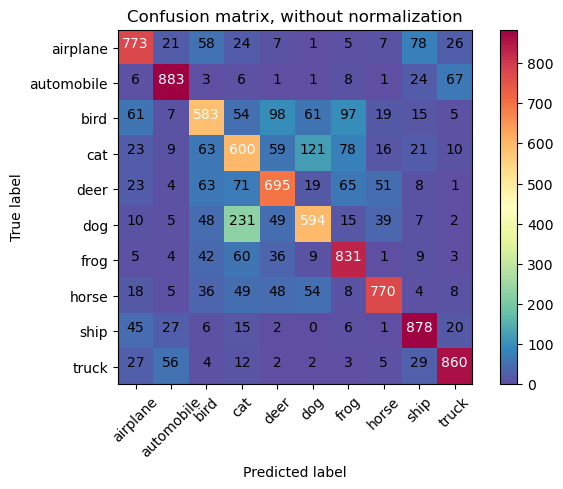

In [30]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_J_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_J_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

In [ ]:
model_10 = Sequential()
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                    input_shape=(32, 32, 3)))
model_10.add(MaxPooling2D((4, 4)))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_10.add(MaxPooling2D((4, 4)))
model_10.add(Dropout(0.4))
model_10.add(Flatten())
model_10.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax'))

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model_10)

quant_aware_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(filepath='model_10_Reduced_K_QAT.h5', save_freq='epoch')

quant_aware_model.summary()

# Train and evaluate the quantization aware model
quant_aware_model.fit(x_train,y_train, batch_size=64,epochs=400,
                      callbacks=[checkpoint_callback],validation_data=(x_test, y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_10 (Quantize  (None, 32, 32, 3)        3         
 Layer)                                                          
                                                                 
 quant_conv2d_49 (QuantizeWr  (None, 32, 32, 32)       963       
 apperV2)                                                        
                                                                 
 quant_max_pooling2d_27 (Qua  (None, 8, 8, 32)         1         
 ntizeWrapperV2)                                                 
                                                                 
 quant_dropout_37 (QuantizeW  (None, 8, 8, 32)         1         
 rapperV2)                                                       
                                                                 
 quant_conv2d_50 (QuantizeWr  (None, 8, 8, 32)       

Epoch 40/400
782/782 [==============================] - 5s 6ms/step - loss: 1.5206 - accuracy: 0.4458 - val_loss: 1.3368 - val_accuracy: 0.5265
Epoch 41/400
782/782 [==============================] - 5s 6ms/step - loss: 1.5148 - accuracy: 0.4481 - val_loss: 1.3274 - val_accuracy: 0.5391
Epoch 42/400
782/782 [==============================] - 4s 6ms/step - loss: 1.5110 - accuracy: 0.4518 - val_loss: 1.3365 - val_accuracy: 0.5379
Epoch 43/400
782/782 [==============================] - 5s 6ms/step - loss: 1.5025 - accuracy: 0.4518 - val_loss: 1.3144 - val_accuracy: 0.5395
Epoch 44/400
782/782 [==============================] - 5s 6ms/step - loss: 1.5027 - accuracy: 0.4532 - val_loss: 1.3270 - val_accuracy: 0.5365
Epoch 45/400
782/782 [==============================] - 5s 6ms/step - loss: 1.5005 - accuracy: 0.4532 - val_loss: 1.3104 - val_accuracy: 0.5403
Epoch 46/400
782/782 [==============================] - 5s 6ms/step - loss: 1.4954 - accuracy: 0.4526 - val_loss: 1.3084 - val_accuracy:

Epoch 97/400
782/782 [==============================] - 5s 6ms/step - loss: 1.3625 - accuracy: 0.5109 - val_loss: 1.1577 - val_accuracy: 0.5978
Epoch 98/400
782/782 [==============================] - 5s 6ms/step - loss: 1.3648 - accuracy: 0.5108 - val_loss: 1.1493 - val_accuracy: 0.6050
Epoch 99/400
782/782 [==============================] - 4s 6ms/step - loss: 1.3604 - accuracy: 0.5102 - val_loss: 1.1723 - val_accuracy: 0.5918
Epoch 100/400
782/782 [==============================] - 5s 6ms/step - loss: 1.3575 - accuracy: 0.5143 - val_loss: 1.1596 - val_accuracy: 0.5932
Epoch 101/400
782/782 [==============================] - 4s 6ms/step - loss: 1.3544 - accuracy: 0.5163 - val_loss: 1.1917 - val_accuracy: 0.5832
Epoch 102/400
782/782 [==============================] - 5s 6ms/step - loss: 1.3514 - accuracy: 0.5157 - val_loss: 1.1632 - val_accuracy: 0.5903
Epoch 103/400
782/782 [==============================] - 5s 6ms/step - loss: 1.3570 - accuracy: 0.5142 - val_loss: 1.1560 - val_accur

In [ ]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(x_test, y_test, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

open("model_10_Reduced_K_QAT.tflite", "wb").write(tflite_model_quant_int8_qat)

In [ ]:
c_model_name = 'cifar10_reduced_k_qat'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

In [ ]:
tflite_interpreter = tf.lite.Interpreter("model_10_Reduced_K_QAT.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predictions = np.zeros((len(x_test),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(x_test)):
    val_batch = x_test[i]
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()
    
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 10000
print("Accuracy of model_10_Reduced_K_QAT.tflite is {}%".format(accuracy_score*100))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())